<a href="https://colab.research.google.com/github/BillWorstell/BaF2_LAPPD/blob/main/SimpleOpticsDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Add the element of detector timing jitter (for LAPPD) to our Pytorch specular optics TOFPET detector first photoelectron timing model

Set up and install needed packages

Import Pytorch

Import numpy, matplotlib, and icecream if needed

In [1]:
# import whatever packages may be needed and report versions
import sys
#Check python version
print('Python version=', sys.version)
#
#Geet Pytorch and set random number seed
import torch
print('Pytorch version=', torch.__version__)
torch.manual_seed(42)
#
#Numpy and Matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import cm
#
!pip install icecream
from icecream import ic

Python version= 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
Pytorch version= 2.1.0+cu118


Define a Struct class for passing associated sets of function call parameters

In [2]:
class Struct:
    def __init__(self, *args): # constructor
        if len(args) == 0:
            self.i = 0
        else:
            i=0
            for arg in args:
                arg_str = arg[0]
                # store arguments as attributes
                setattr(self, arg_str, arg[1]) #self.arg1 = <value>
            self.i = i

RunControl object: Stores run control parameters

In [3]:
RunControl=Struct(['NEvents', 1000],['NPhotons',10000], ['XBounds',[-12.0, 12.0]],['YBounds',[-12.0, 12.0]],['ZBounds',[0, 45.0]])
#
NEvents=RunControl.NEvents
NPhotons=RunControl.NPhotons
XBounds=RunControl.XBounds
YBounds=RunControl.YBounds
ZBounds=RunControl.ZBounds

ic(NEvents)
ic(NPhotons)
ic(XBounds)
ic(YBounds)
ic(ZBounds)

ic| NEvents: 1000
ic| NPhotons: 10000
ic| XBounds: [-12.0, 12.0]
ic| YBounds: [-12.0, 12.0]
ic| ZBounds: [0, 45.0]


[0, 45.0]

In [4]:
def Source(RunControl):
  #
  # Define the ranges for source emission
  #
  # Common source position for all events in X and Y
  XBounds=RunControl.XBounds
  YBounds=RunControl.YBounds
  ZBounds=RunControl.ZBounds
  NEvents=RunControl.NEvents
  NPhotons=RunControl.NPhotons
  #
  # Distribute events uniformly over 3D range, with a common
  #  emission point for all photons in an event
  SourceX0=XBounds[0]+(XBounds[1]-XBounds[0])*torch.rand(NEvents)
  SourceX=SourceX0.repeat_interleave(NPhotons)
  SourceX=torch.reshape(SourceX,[NEvents,NPhotons])
  SourceY0=YBounds[0]+(YBounds[1]-YBounds[0])*torch.rand(NEvents)
  SourceY=SourceY0.repeat_interleave(NPhotons)
  SourceY=torch.reshape(SourceY,[NEvents,NPhotons])
  SourceZ0=ZBounds[0]+(ZBounds[1]-ZBounds[0])*torch.rand(NEvents)
  SourceZ=SourceZ0.repeat_interleave(NPhotons)
  SourceZ=torch.reshape(SourceZ,[NEvents,NPhotons])
  #
  ic(SourceZ.size())
  ic(SourceZ[0][0])
  ic(SourceZ[1][0])
  ic(SourceZ[0][1])
  #
  # Return
  #
  return SourceX, SourceY, SourceZ

SourceX, SourceY, SourceZ = Source(RunControl)
ic(SourceX.size())
ic(SourceY.size())
ic(SourceZ.size())

ic| SourceZ.size(): torch.Size([1000, 10000])
ic| SourceZ[0][0]: tensor(17.7314)
ic| SourceZ[1][0]: tensor(8.8440)
ic| SourceZ[0][1]: tensor(17.7314)
ic| SourceX.size(): torch.Size([1000, 10000])
ic| SourceY.size(): torch.Size([1000, 10000])
ic| SourceZ.size(): torch.Size([1000, 10000])


torch.Size([1000, 10000])

Parametrize Detector Optics

In [5]:
PhPerMeV=1400./(0.035+0.14)
#PE=511 keV * Ph/keV * fraction * QE
PEs1=int(np.floor((0.511*PhPerMeV*.035)*0.30))
PEs2=int(np.floor((0.511*PhPerMeV*.140)*0.30))
PEs3=int(np.floor((0.511*PhPerMeV*.825)*0.35))
Optics=Struct(['IndexX', 1.0],['IndexY',1.40], ['IndexBaF2',[1.55, 1.55, 1.50]],['DecayT',[74,791,602000]],['PEs',[PEs1,PEs2,PEs3]],['ReflectX',0.9],['ReflectY',0.9],['ReflectZ',0.9])

ic(Optics.IndexX)
ic(Optics.IndexY)
ic(Optics.IndexBaF2)
ic(Optics.DecayT)
ic(Optics.PEs)
ic(Optics.ReflectX)
ic(Optics.ReflectY)
ic(Optics.ReflectZ)

ic| Optics.IndexX: 1.0
ic| Optics.IndexY: 1.4
ic| Optics.IndexBaF2: [1.55, 1.55, 1.5]
ic| Optics.DecayT: [74, 791, 602000]
ic| Optics.PEs: [42, 171, 1180]
ic| Optics.ReflectX: 0.9
ic| Optics.ReflectY: 0.9
ic| Optics.ReflectZ: 0.9


0.9

Parametrize Detector Geometry

In [6]:
#Constant Geometry Parameters
Geometry=Struct(['DetectNX', 8],['dX',3.0],['DetectNX', 8],['dX', 3.0],['DetectNY', 12],['dY',2.0],['DetectorNZ', 15],['dZ',3.0])

DetectNX=Geometry.DetectNX
DetectNY=Geometry.DetectNY
DetectorNZ=Geometry.DetectorNZ
TMax=1000.
dX=Geometry.dX
dY=Geometry.dY
dZ=Geometry.dZ
dT=50.
DX = DetectNX * dX
DY = DetectNY * dY
DZ = DetectorNZ * dZ
DT=TMax
DetectorNT=int(np.floor(DT/dT))

ic(dX)
ic(DX)
ic(DetectNX)
ic(dY)
ic(DY)
ic(DetectNY)
ic(dZ)
ic(DZ)
ic(DetectorNZ)
ic(dT)
ic(DT)
ic(DetectorNT)

ic| dX: 3.0
ic| DX: 24.0
ic| DetectNX: 8
ic| dY: 2.0
ic| DY: 24.0
ic| DetectNY: 12
ic| dZ: 3.0
ic| DZ: 45.0
ic| DetectorNZ: 15
ic| dT: 50.0
ic| DT: 1000.0
ic| DetectorNT: 20


20

Parametrize Photosensor Response

In [7]:
#Constant Sensor Parameters
#Sensor=Struct(['SPTRps',165.])
Sensor=Struct(['SPTRps',80.])

SPTRps=Sensor.SPTRps
SPTRsigma=SPTRps/2.35

ic(SPTRps)
ic(SPTRsigma)


ic| SPTRps: 80.0
ic| SPTRsigma: 34.04255319148936


34.04255319148936

Set up for multiple passes over different emission species with different intensities and lifetimes - just fast but not fastest component for now

Get critical angles at optical interfaces based on optical indices.




Fastest Component Only

In [8]:
#Loop over photon emission species [Fastest,Fast,Slow]
AllDetectX=torch.zeros(3,NEvents,NPhotons)
AllDetectY=torch.zeros(3,NEvents,NPhotons)
AllDetectT=torch.zeros(3,NEvents,NPhotons)
AllSurviveReflect=torch.zeros(3,NEvents,NPhotons)
AllSurviveSample=torch.zeros(3,NEvents,NPhotons)
MeanNSurviveSample=np.zeros(3,dtype=float)

AllTMinErrorFWHM=torch.zeros(3,NEvents)
AllTMinDetect=TMax*torch.ones(3,NEvents)

photon_passes = {'Fastest',(Optics.PEs[0], Optics.IndexBaF2[0]),'Fast', (Optics.PEs[1], Optics.IndexBaF2[1]), 'Slow', (Optics.PEs[2], Optics.IndexBaF2[2])}
#
#for iPhotonPass in ['Fastest','Fast','Slow']:
#for iPhotonPass in [0:2]:

#for iPhotonPass in [0,1,2]:
#
# FASTEST COMPONENT ONLY
#
for iPhotonPass in [0]:
  PEs = Optics.PEs[iPhotonPass]
  Index = Optics.IndexBaF2[iPhotonPass]
  CMMPerPs = 0.3/Index
  #
  # Calculate critical angle for total internal reflection at interface
  SinThetaCriticalX=torch.tensor(Optics.IndexX/Index)
  SinThetaCriticalY=torch.tensor(Optics.IndexY/Index)
  PhotonOptics=Struct(['iPhotonPass',iPhotonPass],['PEs',PEs],['Index',Index],['CMMPerPs',CMMPerPs],['SinThetaCriticalX',SinThetaCriticalX],['SinThetaCriticalY',SinThetaCriticalY])
  #
  # Treat Reflectivity as independent of wavelength for the moment
  #  (i.e. take from Optics rather than PhotonOptics)
  ReflectX=Optics.ReflectX
  ReflectY=Optics.ReflectY
  ReflectZ=Optics.ReflectZ
  IndexX=Optics.IndexX
  IndexY=Optics.IndexY
  iPhotonPass=PhotonOptics.iPhotonPass
  NPEs=PhotonOptics.PEs
  CMMPerPs=PhotonOptics.CMMPerPs
  SinThetaCriticalX=PhotonOptics.SinThetaCriticalX
  SinThetaCriticalY=PhotonOptics.SinThetaCriticalY
  #
  # Random isotropic distributions for all photons, all events
  CosZSample=1.-2.*torch.rand(NEvents,NPhotons)
  torch.pi = torch.acos(torch.zeros(1)).item() * 2 # which is 3.1415927410125732
  PhiSample=2.*torch.pi*torch.rand(NEvents,NPhotons)
  #
  R = torch.sqrt(1.-torch.square(CosZSample))
  vX = CMMPerPs * R * torch.cos(PhiSample)
  vY = CMMPerPs * R * torch.sin(PhiSample)
  vZ = CMMPerPs * CosZSample
  SinTheta=CosZSample
  SinPhi=torch.sin(PhiSample)
  #
  #Clip to remove division by zero
  vZ=torch.where(torch.abs(vZ)>0.0000001,vZ,0.0000001)
  #
  # Calculate Photon Collection Time
  #SourceX, SourceY, SourceZ = Source(RunControl)
  TTop=torch.divide(((2.*DZ)-SourceZ),vZ)
  TBottom=torch.divide(((0.*DZ)-SourceZ),vZ)
  TCollect=torch.maximum(TTop,TBottom)
  vXCollect=SourceX +torch.multiply(vX,TCollect)
  vYCollect=SourceY +torch.multiply(vY,TCollect)
  TCollect=torch.maximum(torch.tensor(0.000001),TCollect)
  TCollect=torch.minimum(torch.tensor(TMax),TCollect)
  #
  # Calculate critical angle for total internal reflection at interface
  # Set up data structures for 6 different reflection type cases
  # depending on signs of VX, VY, snf vZ. Indices of medium and reflector then
  # provide critical angle for this reflection to be total internal
  #
  # Calculate critical angle for total internal reflection at interface
  SinThetaCriticalX=IndexX/Index
  SinThetaCriticalY=IndexY/Index
  #
  # Set up data structures for 6 different reflection type cases
  # depending on signs of VX, VY, snf vZ. Indices of medium and reflector then
  # provide critical angle for this reflection to be total internal
  #
  # Condition for total internal reflection off X or Y planes
  TIRX=torch.abs(SinTheta)>torch.abs(torch.tensor(SinThetaCriticalX))
  TIRY=torch.abs(SinTheta)>torch.abs(torch.tensor(SinThetaCriticalY))
  #
  #Distance between reflections
  DReflectX=torch.where(TIRX,dX,DX)
  DReflectY=torch.where(TIRY,dY,DY)
  #
  #Unfold hall of mirrors into virtual detector
  # Virtual detector collection ray lengths
  DVXCollect=torch.abs(vX)*TCollect
  DVYCollect=torch.abs(vY)*TCollect
  #
  # Find Collection coordinates in virtual detector
  VXDetect=SourceX + torch.multiply(TCollect,vX)
  VYDetect=SourceY + torch.multiply(TCollect,vY)
  #
  # Get offset of virtual detection position unit cell center
  OffsetX=torch.where(vX>0,torch.remainder(VXDetect+(DX/2),DReflectX)-(DReflectX/2),-torch.remainder(-VXDetect+(DReflectX/2),DReflectX)+(DReflectX/2))
  OffsetY=torch.where(vY>0,torch.remainder(VYDetect+(DY/2),DReflectY)-(DReflectY/2),-torch.remainder(-VYDetect+(DReflectY/2),DReflectY)+(DReflectY/2))
  #
  # Get offset of virtual detection point within unit cell
  XOffset=torch.where(VXDetect>0,DReflectX*torch.floor_divide(VXDetect,DReflectX),DReflectX*torch.floor_divide(-VXDetect,DReflectX))
  YOffset=torch.where(VYDetect>0,DReflectY*torch.floor_divide(VYDetect,DReflectY),DReflectY*torch.floor_divide(-VYDetect,DReflectY))
  #
  # Check whether first reflection is before being detected
  TFirstX=torch.empty(vX.shape,dtype=float)
  TFirstY=torch.empty(vY.shape,dtype=float)
  TFirstX=torch.where(torch.multiply(vX>0,~TIRX),torch.divide((DX/2.)-SourceX,vX),TFirstX)
  TFirstX=torch.where(torch.multiply(vX<0,~TIRX),torch.divide(SourceX-(DX/2.),vX),TFirstX)
  TFirstX=torch.where(torch.multiply(vX>0, TIRX),torch.divide((dX/2.)-(SourceX-XOffset),vX),TFirstX)
  TFirstX=torch.where(torch.multiply(vX<0, TIRX),torch.divide((XOffset-SourceX)-(dX/2.),vX),TFirstX)
  TFirstY=torch.where(torch.multiply(vY>0,~TIRY),torch.divide((DY/2.)-SourceY,vY),TFirstY)
  TFirstY=torch.where(torch.multiply(vY<0,~TIRY),torch.divide(SourceY-(DY/2.),vY),TFirstY)
  TFirstY=torch.where(torch.multiply(vY>0, TIRY),torch.divide((dY/2.)-(SourceY-YOffset),vY),TFirstY)
  TFirstY=torch.where(torch.multiply(vY<0, TIRY),torch.divide((YOffset-SourceY)-(dY/2.),vY),TFirstY)
  #
  # Number Reflections resulting in complete transits of unit cell
  NXWallToWall=torch.floor(DVXCollect/DReflectX)
  NYWallToWall=torch.floor(DVYCollect/DReflectY)
  #
  # Get time for traversal of all wall-to-wall reflection pairs
  TXWallToWall=torch.divide(torch.multiply(DReflectX,NXWallToWall),torch.abs(vX))
  TYWallToWall=torch.divide(torch.multiply(DReflectY,NYWallToWall),torch.abs(vY))
  #
  # Check time of first reflection
  NXWalltoWall=torch.where(TCollect<TFirstX,0,NXWallToWall)
  NYWallToWall=torch.where(TCollect<TFirstY,0,NYWallToWall)
  TLastX=torch.where(TCollect<TFirstX,0,TFirstX+TXWallToWall)
  TLastY=torch.where(TCollect<TFirstY,0,TFirstY+TYWallToWall)
  #
  # If there is no reflection before finst detection, decrement the Reflection counter
  NXWalltoWall=torch.where(TCollect<TFirstX,torch.maximum(torch.tensor([0]),NXWallToWall-1),NXWallToWall)
  NYWallToWall=torch.where(TCollect<TFirstY,torch.maximum(torch.tensor([0]),NYWallToWall-1),NYWallToWall)
  # If there is no reflection before final detection, decrement the Reflection counter
  NXWalltoWall=torch.where(TCollect<TLastX,torch.maximum(torch.tensor([0]),NXWallToWall-1),NXWallToWall)
  NYWallToWall=torch.where(TCollect<TLastY,torch.maximum(torch.tensor([0]),NYWallToWall-1),NYWallToWall)
  #
  # If there is a reflection before detection, increment the Reflection counter
  NXReflect=torch.where(TCollect<TFirstX,0,NXWallToWall+1)
  NYReflect=torch.where(TCollect<TFirstY,0,NYWallToWall+1)
  #
  # Get Reflection Survival Probability
  SurviveXReflect=torch.where(TIRX,1.,torch.pow(ReflectX,NXReflect))
  SurviveYReflect=torch.where(TIRY,1.,torch.pow(ReflectY,NYReflect))
  SurviveZReflect=torch.where(vZ>0,ReflectZ,1.)
  SurviveReflect=torch.multiply(torch.multiply(SurviveXReflect,SurviveYReflect),SurviveZReflect)
  #
  # Shift the TIR photons to their TIR unit cell, and allow for round-off error
  XDetect=OffsetX
  YDetect=OffsetY
  XDetect=torch.where(TIRX, XDetect+dX*(torch.floor_divide(SourceX+(DX/2),dX)-((DX/dX)/2)+(1/2)),XDetect)
  XDetect=torch.maximum(XDetect,-(DX/2.)+torch.tensor(0.00001))
  XDetect=torch.minimum(XDetect, (DX/2.)-torch.tensor(0.00001))
  YDetect=torch.where(TIRY, YDetect+dY*(torch.floor_divide(SourceY+(DY/2),dY)-((DY/dY)/2)+(1/2)),YDetect)
  YDetect=torch.maximum(YDetect,-(DY/2.)+torch.tensor(0.00001))
  YDetect=torch.minimum(YDetect, (DY/2.)-torch.tensor(0.00001))
  #
  # Optics.DecayT: [74, 791, 602000]
  ic(Optics.DecayT[iPhotonPass])
  TEmit=Optics.DecayT[iPhotonPass]*(-torch.log(torch.rand(NEvents,NPhotons)))
  ic(TEmit[0][0])
  TSensor=torch.normal(mean=torch.zeros(NEvents,NPhotons), std=SPTRsigma*torch.ones(NEvents,NPhotons))
  TDetect=TCollect+TEmit+TSensor
  ic(TDetect[0][0])
  #
  AllDetectX[iPhotonPass,:,:]=XDetect
  AllDetectY[iPhotonPass,:,:]=YDetect
  AllDetectT[iPhotonPass,:,:]=TDetect
  AllSurviveReflect[iPhotonPass,:,:]=SurviveReflect
  #
  # NPEs = Optics.PEs[iPhotonPass]
  ic(NPEs)
  SurviveSample=torch.zeros(NEvents,NPhotons)
  ScaledSurvival=SurviveReflect*(NPEs/NPhotons)
  ISurvive=ScaledSurvival>torch.rand(NEvents,NPhotons)
  SampleT=torch.where(ISurvive,TDetect,TMax)
  NSurviveSample=torch.sum(ISurvive,dim=1)
  ic(NSurviveSample[0:9])
  AllSurviveSample[iPhotonPass,:,:]=ISurvive
  #
  SampleMinT=np.where(ISurvive,TDetect,TMax)
  ic(SampleMinT.shape)
  TMinDetect=np.min(SampleMinT,axis=1)
  ic(TMinDetect.shape)
  ic(TMinDetect[0])
  ic(TCollect[0])
  AllTMinDetect[iPhotonPass,:]=torch.tensor(TMinDetect)
  MeanNSurviveSample[iPhotonPass]=(NSurviveSample.numpy()).mean()

ic(AllTMinDetect.size())
TMinDetect=np.min(AllTMinDetect.numpy(),axis=0)

ic| Optics.DecayT[iPhotonPass]: 74
ic| TEmit[0][0]: tensor(43.8391)
ic| TDetect[0][0]: tensor(155.4761)
ic| NPEs: 42
ic| NSurviveSample[0:9]: tensor([32, 22, 32, 28, 23, 35, 23, 19, 30])
ic| SampleMinT.shape: (1000, 10000)
ic| TMinDetect.shape: (1000,)
ic| TMinDetect[0]: 51.995945
ic| TCollect[0]: tensor([ 118.9964,  122.2004,  268.5638,  ...,  677.9584,  152.3767,
                         1000.0000])
ic| AllTMinDetect.size(): torch.Size([3, 1000])


Display for Fastest Component Only

ic| npTCollect.shape: (1000, 10000)
ic| npSourceZ.shape: (1000, 10000)
ic| SourceZTMin.size: 1000
ic| SourceZTMin.size: 1000


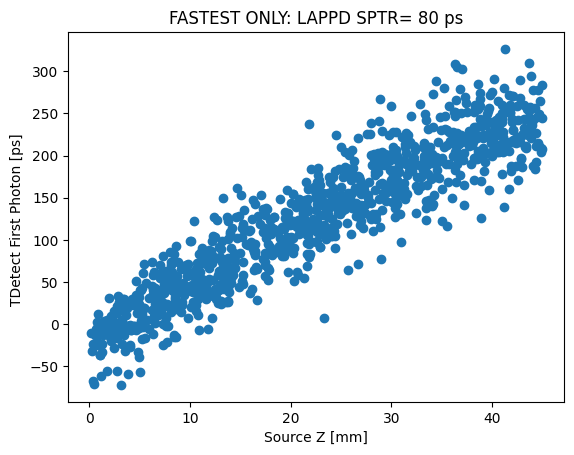

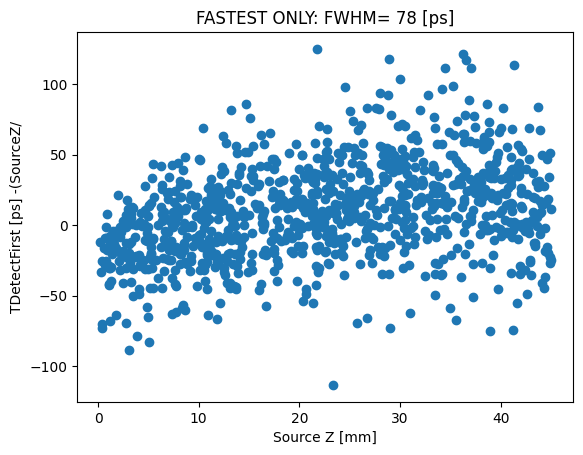

In [9]:
npTCollect=np.reshape(TCollect.numpy(),[NEvents,NPhotons])
ic(npTCollect.shape)
npSourceZ=np.reshape(SourceZ.numpy(),[NEvents,NPhotons])
ic(npSourceZ.shape)

#TCollectTMin=np.min(npTCollect,axis=1)
#ic(TCollectTMin.shape)

#ITCollectTMin=np.squeeze(TCollectTMin,axis=1)
#ITCollectTMin=np.amin(npTCollect,axis=1).astype(int)
#ic(ITCollectTMin.shape)
SourceZTMin=np.squeeze(npSourceZ[:,0])
ic(SourceZTMin.size)

for iEvent in range(NEvents):
  SourceZTMin[iEvent]=npSourceZ[iEvent][[iEvent] ]

ic(SourceZTMin.size)
plt.scatter(SourceZTMin,TMinDetect)
#plt.title("FASTEST ONLY: First Photon Detection Time vs. Source Z" )
plt.title("FASTEST ONLY: LAPPD SPTR= " + str(int(SPTRps))+ " ps" )
plt.xlabel("Source Z [mm]")
plt.ylabel("TDetect First Photon [ps] ")
plt.show()

TminError=TMinDetect-(SourceZTMin/CMMPerPs)
TminErrorFWHM=2.35* np.std(TminError)
TminError=np.maximum(-200,TminError)
plt.scatter(SourceZTMin,TminError)
plt.title("FASTEST ONLY: FWHM= " + str(int(np.floor(TminErrorFWHM))) + " [ps]")
plt.xlabel("Source Z [mm]")
plt.ylabel("TDetectFirst [ps] -(SourceZ/")
plt.show()

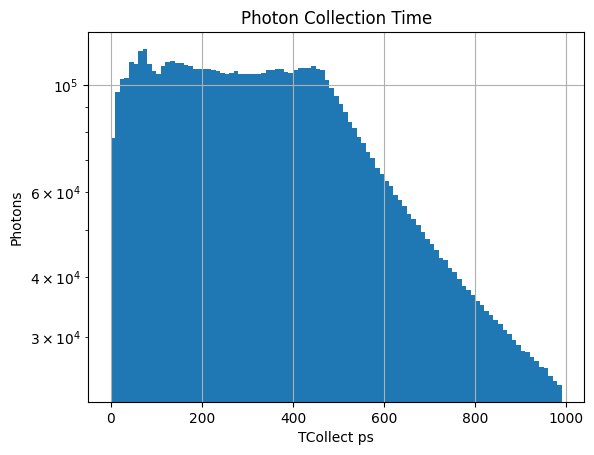

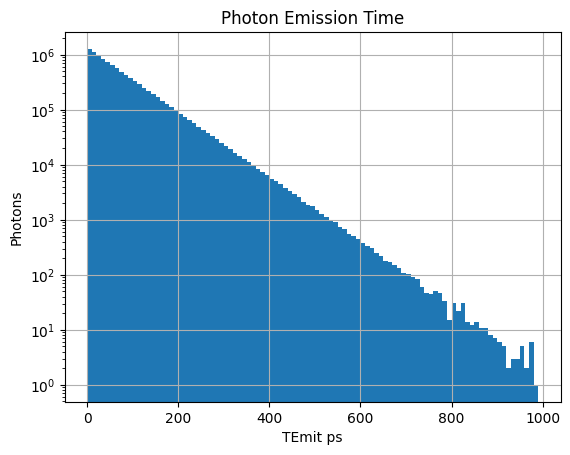

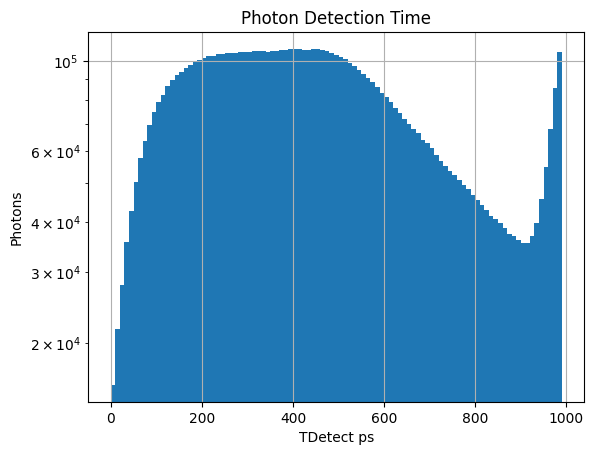

In [10]:
HValues=(TCollect.flatten()).numpy()
HValues=HValues[HValues<1000]
HBins=np.arange(0,1000,10)

plt.hist(HValues, bins=HBins)
plt.xlabel('TCollect ps')
plt.ylabel('Photons')
plt.title('Photon Collection Time')
plt.grid()
plt.yscale('log')
plt.show()

HValues=(TEmit.flatten()).numpy()
HValues=HValues[HValues<1000]
HBins=np.arange(0,1000,10)

plt.hist(HValues, bins=HBins)
plt.xlabel('TEmit ps')
plt.ylabel('Photons')
plt.title('Photon Emission Time')
plt.grid()
plt.yscale('log')
plt.show()

HValues=(TDetect.flatten()).numpy()
HValues=HValues[HValues<1000]
HBins=np.arange(0,1000,10)

plt.hist(HValues, bins=HBins)
plt.xlabel('TDetect ps')
plt.ylabel('Photons')
plt.title('Photon Detection Time')
plt.grid()
plt.yscale('log')
plt.show()

Fast Component Only

In [11]:
# Loop over photon emission species [Fastest,Fast,Slow]
AllDetectX=torch.zeros(3,NEvents,NPhotons)
AllDetectY=torch.zeros(3,NEvents,NPhotons)
AllDetectT=torch.zeros(3,NEvents,NPhotons)
AllSurviveReflect=torch.zeros(3,NEvents,NPhotons)
AllSurviveSample=torch.zeros(3,NEvents,NPhotons)
MeanNSurviveSample=np.zeros(3,dtype=float)

AllTMinDetect=TMax*torch.ones(3,NEvents)
AllTMinErrorFWHM=torch.zeros(3,NEvents)

photon_passes = {'Fastest',(Optics.PEs[0], Optics.IndexBaF2[0]),'Fast', (Optics.PEs[1], Optics.IndexBaF2[1]), 'Slow', (Optics.PEs[2], Optics.IndexBaF2[2])}
#
#for iPhotonPass in ['Fastest','Fast','Slow']:
#for iPhotonPass in [0:2]:
#
#for iPhotonPass in 'Fast'
#for iPhotonPass in [0,1,2]:
#
# FAST COMPONENT ONLY
#
for iPhotonPass in [1]:
  PEs = Optics.PEs[iPhotonPass]
  Index = Optics.IndexBaF2[iPhotonPass]
  CMMPerPs = 0.3/Index
  #
  # Calculate critical angle for total internal reflection at interface
  SinThetaCriticalX=torch.tensor(Optics.IndexX/Index)
  SinThetaCriticalY=torch.tensor(Optics.IndexY/Index)
  PhotonOptics=Struct(['iPhotonPass',iPhotonPass],['PEs',PEs],['Index',Index],['CMMPerPs',CMMPerPs],['SinThetaCriticalX',SinThetaCriticalX],['SinThetaCriticalY',SinThetaCriticalY])
  #
  # Treat Reflectivity as independent of wavelength for the moment
  #  (i.e. take from Optics rather than PhotonOptics)
  ReflectX=Optics.ReflectX
  ReflectY=Optics.ReflectY
  ReflectZ=Optics.ReflectZ
  IndexX=Optics.IndexX
  IndexY=Optics.IndexY
  iPhotonPass=PhotonOptics.iPhotonPass
  NPEs=PhotonOptics.PEs
  CMMPerPs=PhotonOptics.CMMPerPs
  SinThetaCriticalX=PhotonOptics.SinThetaCriticalX
  SinThetaCriticalY=PhotonOptics.SinThetaCriticalY
  #
  # Random isotropic distributions for all photons, all events
  CosZSample=1.-2.*torch.rand(NEvents,NPhotons)
  torch.pi = torch.acos(torch.zeros(1)).item() * 2 # which is 3.1415927410125732
  PhiSample=2.*torch.pi*torch.rand(NEvents,NPhotons)
  #
  R = torch.sqrt(1.-torch.square(CosZSample))
  vX = CMMPerPs * R * torch.cos(PhiSample)
  vY = CMMPerPs * R * torch.sin(PhiSample)
  vZ = CMMPerPs * CosZSample
  SinTheta=CosZSample
  SinPhi=torch.sin(PhiSample)
  #
  #Clip to remove division by zero
  vZ=torch.where(torch.abs(vZ)>0.0000001,vZ,0.0000001)
  #
  # Calculate Photon Collection Time
  #SourceX, SourceY, SourceZ = Source(RunControl)
  TTop=torch.divide(((2.*DZ)-SourceZ),vZ)
  TBottom=torch.divide(((0.*DZ)-SourceZ),vZ)
  TCollect=torch.maximum(TTop,TBottom)
  vXCollect=SourceX +torch.multiply(vX,TCollect)
  vYCollect=SourceY +torch.multiply(vY,TCollect)
  TCollect=torch.maximum(torch.tensor(0.000001),TCollect)
  TCollect=torch.minimum(torch.tensor(TMax),TCollect)
  #
  # Calculate critical angle for total internal reflection at interface
  # Set up data structures for 6 different reflection type cases
  # depending on signs of VX, VY, snf vZ. Indices of medium and reflector then
  # provide critical angle for this reflection to be total internal
  #
  # Calculate critical angle for total internal reflection at interface
  SinThetaCriticalX=IndexX/Index
  SinThetaCriticalY=IndexY/Index
  #
  # Set up data structures for 6 different reflection type cases
  # depending on signs of VX, VY, snf vZ. Indices of medium and reflector then
  # provide critical angle for this reflection to be total internal
  #
  # Condition for total internal reflection off X or Y planes
  TIRX=torch.abs(SinTheta)>torch.abs(torch.tensor(SinThetaCriticalX))
  TIRY=torch.abs(SinTheta)>torch.abs(torch.tensor(SinThetaCriticalY))
  #
  #Distance between reflections
  DReflectX=torch.where(TIRX,dX,DX)
  DReflectY=torch.where(TIRY,dY,DY)
  #
  #Unfold hall of mirrors into virtual detector
  # Virtual detector collection ray lengths
  DVXCollect=torch.abs(vX)*TCollect
  DVYCollect=torch.abs(vY)*TCollect
  #
  # Find Collection coordinates in virtual detector
  VXDetect=SourceX + torch.multiply(TCollect,vX)
  VYDetect=SourceY + torch.multiply(TCollect,vY)
  #
  # Get offset of virtual detection position unit cell center
  OffsetX=torch.where(vX>0,torch.remainder(VXDetect+(DX/2),DReflectX)-(DReflectX/2),-torch.remainder(-VXDetect+(DReflectX/2),DReflectX)+(DReflectX/2))
  OffsetY=torch.where(vY>0,torch.remainder(VYDetect+(DY/2),DReflectY)-(DReflectY/2),-torch.remainder(-VYDetect+(DReflectY/2),DReflectY)+(DReflectY/2))
  #
  # Get offset of virtual detection point within unit cell
  XOffset=torch.where(VXDetect>0,DReflectX*torch.floor_divide(VXDetect,DReflectX),DReflectX*torch.floor_divide(-VXDetect,DReflectX))
  YOffset=torch.where(VYDetect>0,DReflectY*torch.floor_divide(VYDetect,DReflectY),DReflectY*torch.floor_divide(-VYDetect,DReflectY))
  #
  # Check whether first reflection is before being detected
  TFirstX=torch.empty(vX.shape,dtype=float)
  TFirstY=torch.empty(vY.shape,dtype=float)
  TFirstX=torch.where(torch.multiply(vX>0,~TIRX),torch.divide((DX/2.)-SourceX,vX),TFirstX)
  TFirstX=torch.where(torch.multiply(vX<0,~TIRX),torch.divide(SourceX-(DX/2.),vX),TFirstX)
  TFirstX=torch.where(torch.multiply(vX>0, TIRX),torch.divide((dX/2.)-(SourceX-XOffset),vX),TFirstX)
  TFirstX=torch.where(torch.multiply(vX<0, TIRX),torch.divide((XOffset-SourceX)-(dX/2.),vX),TFirstX)
  TFirstY=torch.where(torch.multiply(vY>0,~TIRY),torch.divide((DY/2.)-SourceY,vY),TFirstY)
  TFirstY=torch.where(torch.multiply(vY<0,~TIRY),torch.divide(SourceY-(DY/2.),vY),TFirstY)
  TFirstY=torch.where(torch.multiply(vY>0, TIRY),torch.divide((dY/2.)-(SourceY-YOffset),vY),TFirstY)
  TFirstY=torch.where(torch.multiply(vY<0, TIRY),torch.divide((YOffset-SourceY)-(dY/2.),vY),TFirstY)
  #
  # Number Reflections resulting in complete transits of unit cell
  NXWallToWall=torch.floor(DVXCollect/DReflectX)
  NYWallToWall=torch.floor(DVYCollect/DReflectY)
  #
  # Get time for traversal of all wall-to-wall reflection pairs
  TXWallToWall=torch.divide(torch.multiply(DReflectX,NXWallToWall),torch.abs(vX))
  TYWallToWall=torch.divide(torch.multiply(DReflectY,NYWallToWall),torch.abs(vY))
  #
  # Check time of first reflection
  NXWalltoWall=torch.where(TCollect<TFirstX,0,NXWallToWall)
  NYWallToWall=torch.where(TCollect<TFirstY,0,NYWallToWall)
  TLastX=torch.where(TCollect<TFirstX,0,TFirstX+TXWallToWall)
  TLastY=torch.where(TCollect<TFirstY,0,TFirstY+TYWallToWall)
  #
  # If there is no reflection before finst detection, decrement the Reflection counter
  NXWalltoWall=torch.where(TCollect<TFirstX,torch.maximum(torch.tensor([0]),NXWallToWall-1),NXWallToWall)
  NYWallToWall=torch.where(TCollect<TFirstY,torch.maximum(torch.tensor([0]),NYWallToWall-1),NYWallToWall)
  # If there is no reflection before final detection, decrement the Reflection counter
  NXWalltoWall=torch.where(TCollect<TLastX,torch.maximum(torch.tensor([0]),NXWallToWall-1),NXWallToWall)
  NYWallToWall=torch.where(TCollect<TLastY,torch.maximum(torch.tensor([0]),NYWallToWall-1),NYWallToWall)
  #
  # If there is a reflection before detection, increment the Reflection counter
  NXReflect=torch.where(TCollect<TFirstX,0,NXWallToWall+1)
  NYReflect=torch.where(TCollect<TFirstY,0,NYWallToWall+1)
  #
  # Get Reflection Survival Probability
  SurviveXReflect=torch.where(TIRX,1.,torch.pow(ReflectX,NXReflect))
  SurviveYReflect=torch.where(TIRY,1.,torch.pow(ReflectY,NYReflect))
  SurviveZReflect=torch.where(vZ>0,ReflectZ,1.)
  SurviveReflect=torch.multiply(torch.multiply(SurviveXReflect,SurviveYReflect),SurviveZReflect)
  #
  # Shift the TIR photons to their TIR unit cell, and allow for round-off error
  XDetect=OffsetX
  YDetect=OffsetY
  XDetect=torch.where(TIRX, XDetect+dX*(torch.floor_divide(SourceX+(DX/2),dX)-((DX/dX)/2)+(1/2)),XDetect)
  XDetect=torch.maximum(XDetect,-(DX/2.)+torch.tensor(0.00001))
  XDetect=torch.minimum(XDetect, (DX/2.)-torch.tensor(0.00001))
  YDetect=torch.where(TIRY, YDetect+dY*(torch.floor_divide(SourceY+(DY/2),dY)-((DY/dY)/2)+(1/2)),YDetect)
  YDetect=torch.maximum(YDetect,-(DY/2.)+torch.tensor(0.00001))
  YDetect=torch.minimum(YDetect, (DY/2.)-torch.tensor(0.00001))
  #
  # Optics.DecayT: [74, 791, 602000]
  ic(Optics.DecayT[iPhotonPass])
  TEmit=Optics.DecayT[iPhotonPass]*(-torch.log(torch.rand(NEvents,NPhotons)))
  ic(TEmit[0][0])
  #TDetect=TCollect+TEmit
  TSensor=torch.normal(mean=torch.zeros(NEvents,NPhotons), std=SPTRsigma*torch.ones(NEvents,NPhotons))
  TDetect=TCollect+TEmit+TSensor

  ic(TDetect[0][0])
  #
  AllDetectX[iPhotonPass,:,:]=XDetect
  AllDetectY[iPhotonPass,:,:]=YDetect
  AllDetectT[iPhotonPass,:,:]=TDetect
  AllSurviveReflect[iPhotonPass,:,:]=SurviveReflect
  #
  # NPEs = Optics.PEs[iPhotonPass]
  ic(NPEs)
  SurviveSample=torch.zeros(NEvents,NPhotons)
  ScaledSurvival=SurviveReflect*(NPEs/NPhotons)
  ISurvive=ScaledSurvival>torch.rand(NEvents,NPhotons)
  SampleT=torch.where(ISurvive,TDetect,TMax)
  NSurviveSample=torch.sum(ISurvive,dim=1)
  ic(NSurviveSample[0:9])
  AllSurviveSample[iPhotonPass,:,:]=ISurvive
  #
  SampleMinT=np.where(ISurvive,TDetect,TMax)
  ic(SampleMinT.shape)
  TMinDetect=np.min(SampleMinT,axis=1)
  ic(TMinDetect.shape)
  ic(TMinDetect[0])
  ic(TCollect[0])
  AllTMinDetect[iPhotonPass,:]=torch.tensor(TMinDetect)
  MeanNSurviveSample[iPhotonPass]=(NSurviveSample.numpy()).mean()

ic(AllTMinDetect.size())
TMinDetect=np.min(AllTMinDetect.numpy(),axis=0)

TminError=TMinDetect-(SourceZTMin/CMMPerPs)
TminErrorFWHM=2.35* np.std(TminError)

ic| Optics.DecayT[iPhotonPass]: 791
ic| TEmit[0][0]: tensor(500.9217)
ic| TDetect[0][0]: tensor(1468.8179)
ic| NPEs: 171
ic| NSurviveSample[0:9]: tensor([104, 138, 107,  90, 100, 125, 118, 103, 118])
ic| SampleMinT.shape: (1000, 10000)
ic| TMinDetect.shape: (1000,)
ic| TMinDetect[0]: 135.61409
ic| TCollect[0]: tensor([1000.0000,  695.9059,  164.6175,  ...,  247.3742,  137.9383,
                         1000.0000])
ic| AllTMinDetect.size(): torch.Size([3, 1000])


Display for Fast Component Only

ic| npTCollect.shape: (1000, 10000)
ic| npSourceZ.shape: (1000, 10000)
ic| SourceZTMin.size: 1000
ic| SourceZTMin.size: 1000


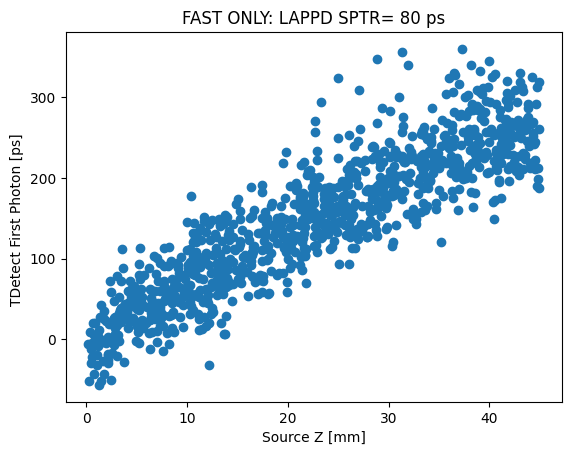

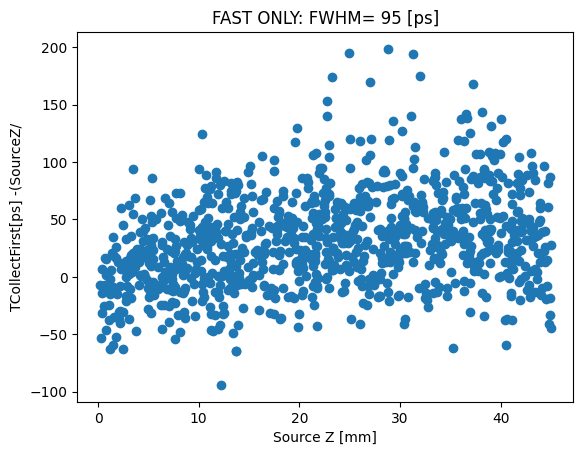

In [12]:
npTCollect=np.reshape(TCollect.numpy(),[NEvents,NPhotons])
ic(npTCollect.shape)
npSourceZ=np.reshape(SourceZ.numpy(),[NEvents,NPhotons])
ic(npSourceZ.shape)

#TCollectTMin=np.min(npTCollect,axis=1)
#ic(TCollectTMin.shape)

#ITCollectTMin=np.squeeze(TCollectTMin,axis=1)
#ITCollectTMin=np.amin(npTCollect,axis=1).astype(int)
#ic(ITCollectTMin.shape)
SourceZTMin=np.squeeze(npSourceZ[:,0])
ic(SourceZTMin.size)

for iEvent in range(NEvents):
  SourceZTMin[iEvent]=npSourceZ[iEvent][[iEvent] ]

ic(SourceZTMin.size)
plt.scatter(SourceZTMin,TMinDetect)
#plt.title("FAST ONLY: First Photon Detection Time vs. Source Z" )
#plt.title("FAST ONLY: MeanNSurviveSample= " + str(int(MeanNSurviveSample[1])) )
plt.title("FAST ONLY: LAPPD SPTR= " + str(int(SPTRps))+ " ps" )

plt.xlabel("Source Z [mm]")
plt.ylabel("TDetect First Photon [ps] ")
plt.show()

TminError=TMinDetect-(SourceZTMin/CMMPerPs)
TminErrorFWHM=2.35* np.std(TminError)
TminError=np.maximum(-200,TminError)
plt.scatter(SourceZTMin,TminError)
plt.title("FAST ONLY: FWHM= " + str(int(np.floor(TminErrorFWHM))) + " [ps]")
plt.xlabel("Source Z [mm]")
plt.ylabel("TCollectFirst[ps] -(SourceZ/")
plt.show()

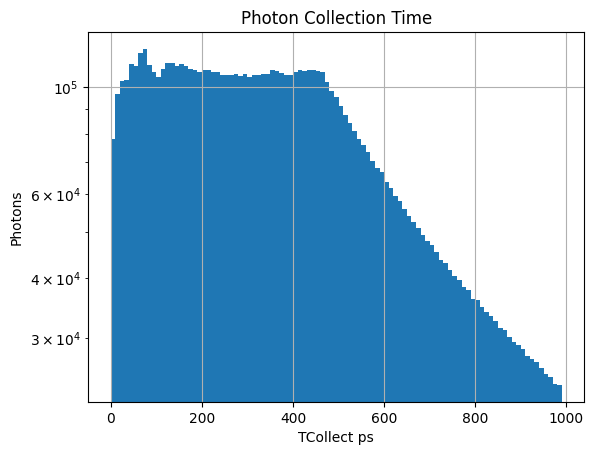

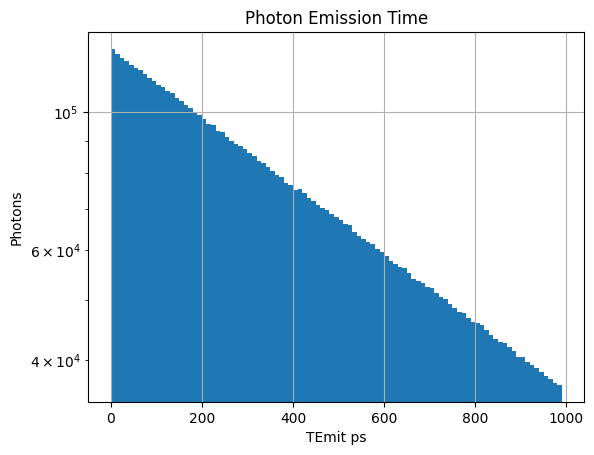

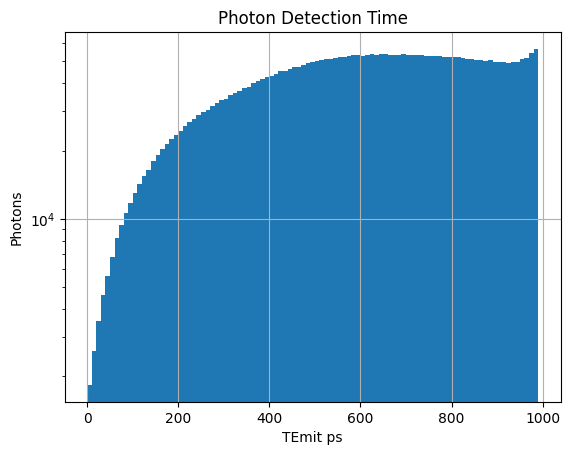

In [13]:
HValues=(TCollect.flatten()).numpy()
HValues=HValues[HValues<1000]
HBins=np.arange(0,1000,10)

plt.hist(HValues, bins=HBins)
plt.xlabel('TCollect ps')
plt.ylabel('Photons')
plt.title('Photon Collection Time')
plt.grid()
plt.yscale('log')
plt.show()

HValues=(TEmit.flatten()).numpy()
HValues=HValues[HValues<1000]
HBins=np.arange(0,1000,10)

plt.hist(HValues, bins=HBins)
plt.xlabel('TEmit ps')
plt.ylabel('Photons')
plt.title('Photon Emission Time')
plt.grid()
plt.yscale('log')
plt.show()

HValues=(TDetect.flatten()).numpy()
HValues=HValues[HValues<1000]
HBins=np.arange(0,1000,10)

plt.hist(HValues, bins=HBins)
plt.xlabel('TEmit ps')
plt.ylabel('Photons')
plt.title('Photon Detection Time')
plt.grid()
plt.yscale('log')
plt.show()

Fast and Fastest Components Combined

In [14]:
# Loop over photon emission species [Fastest,Fast,Slow]
AllDetectX=torch.zeros(3,NEvents,NPhotons)
AllDetectY=torch.zeros(3,NEvents,NPhotons)
AllDetectT=torch.zeros(3,NEvents,NPhotons)
AllSurviveReflect=torch.zeros(3,NEvents,NPhotons)
AllSurviveSample=torch.zeros(3,NEvents,NPhotons)
MeanNSurviveSample=np.zeros(3,dtype=float)

AllTMinDetect=TMax*torch.ones(3,NEvents)
AllTMinErrorFWHM=torch.zeros(3,NEvents)

photon_passes = {'Fastest',(Optics.PEs[0], Optics.IndexBaF2[0]),'Fast', (Optics.PEs[1], Optics.IndexBaF2[1]), 'Slow', (Optics.PEs[2], Optics.IndexBaF2[2])}
#
#for iPhotonPass in ['Fastest','Fast','Slow']:
#for iPhotonPass in [0:2]:
#
#for iPhotonPass in 'Fast'
#for iPhotonPass in [0,1,2]:
#
# FASTEST AND FAST COMPONENTS COMBINED
#
for iPhotonPass in [0,1]:
  PEs = Optics.PEs[iPhotonPass]
  Index = Optics.IndexBaF2[iPhotonPass]
  CMMPerPs = 0.3/Index
  #
  # Calculate critical angle for total internal reflection at interface
  SinThetaCriticalX=torch.tensor(Optics.IndexX/Index)
  SinThetaCriticalY=torch.tensor(Optics.IndexY/Index)
  PhotonOptics=Struct(['iPhotonPass',iPhotonPass],['PEs',PEs],['Index',Index],['CMMPerPs',CMMPerPs],['SinThetaCriticalX',SinThetaCriticalX],['SinThetaCriticalY',SinThetaCriticalY])
  #
  # Treat Reflectivity as independent of wavelength for the moment
  #  (i.e. take from Optics rather than PhotonOptics)
  ReflectX=Optics.ReflectX
  ReflectY=Optics.ReflectY
  ReflectZ=Optics.ReflectZ
  IndexX=Optics.IndexX
  IndexY=Optics.IndexY
  iPhotonPass=PhotonOptics.iPhotonPass
  NPEs=PhotonOptics.PEs
  CMMPerPs=PhotonOptics.CMMPerPs
  SinThetaCriticalX=PhotonOptics.SinThetaCriticalX
  SinThetaCriticalY=PhotonOptics.SinThetaCriticalY
  #
  # Random isotropic distributions for all photons, all events
  CosZSample=1.-2.*torch.rand(NEvents,NPhotons)
  torch.pi = torch.acos(torch.zeros(1)).item() * 2 # which is 3.1415927410125732
  PhiSample=2.*torch.pi*torch.rand(NEvents,NPhotons)
  #
  R = torch.sqrt(1.-torch.square(CosZSample))
  vX = CMMPerPs * R * torch.cos(PhiSample)
  vY = CMMPerPs * R * torch.sin(PhiSample)
  vZ = CMMPerPs * CosZSample
  SinTheta=CosZSample
  SinPhi=torch.sin(PhiSample)
  #
  #Clip to remove division by zero
  vZ=torch.where(torch.abs(vZ)>0.0000001,vZ,0.0000001)
  #
  # Calculate Photon Collection Time
  #SourceX, SourceY, SourceZ = Source(RunControl)
  TTop=torch.divide(((2.*DZ)-SourceZ),vZ)
  TBottom=torch.divide(((0.*DZ)-SourceZ),vZ)
  TCollect=torch.maximum(TTop,TBottom)
  vXCollect=SourceX +torch.multiply(vX,TCollect)
  vYCollect=SourceY +torch.multiply(vY,TCollect)
  TCollect=torch.maximum(torch.tensor(0.000001),TCollect)
  TCollect=torch.minimum(torch.tensor(TMax),TCollect)
  #
  # Calculate critical angle for total internal reflection at interface
  # Set up data structures for 6 different reflection type cases
  # depending on signs of VX, VY, snf vZ. Indices of medium and reflector then
  # provide critical angle for this reflection to be total internal
  #
  # Calculate critical angle for total internal reflection at interface
  SinThetaCriticalX=IndexX/Index
  SinThetaCriticalY=IndexY/Index
  #
  # Set up data structures for 6 different reflection type cases
  # depending on signs of VX, VY, snf vZ. Indices of medium and reflector then
  # provide critical angle for this reflection to be total internal
  #
  # Condition for total internal reflection off X or Y planes
  TIRX=torch.abs(SinTheta)>torch.abs(torch.tensor(SinThetaCriticalX))
  TIRY=torch.abs(SinTheta)>torch.abs(torch.tensor(SinThetaCriticalY))
  #
  #Distance between reflections
  DReflectX=torch.where(TIRX,dX,DX)
  DReflectY=torch.where(TIRY,dY,DY)
  #
  #Unfold hall of mirrors into virtual detector
  # Virtual detector collection ray lengths
  DVXCollect=torch.abs(vX)*TCollect
  DVYCollect=torch.abs(vY)*TCollect
  #
  # Find Collection coordinates in virtual detector
  VXDetect=SourceX + torch.multiply(TCollect,vX)
  VYDetect=SourceY + torch.multiply(TCollect,vY)
  #
  # Get offset of virtual detection position unit cell center
  OffsetX=torch.where(vX>0,torch.remainder(VXDetect+(DX/2),DReflectX)-(DReflectX/2),-torch.remainder(-VXDetect+(DReflectX/2),DReflectX)+(DReflectX/2))
  OffsetY=torch.where(vY>0,torch.remainder(VYDetect+(DY/2),DReflectY)-(DReflectY/2),-torch.remainder(-VYDetect+(DReflectY/2),DReflectY)+(DReflectY/2))
  #
  # Get offset of virtual detection point within unit cell
  XOffset=torch.where(VXDetect>0,DReflectX*torch.floor_divide(VXDetect,DReflectX),DReflectX*torch.floor_divide(-VXDetect,DReflectX))
  YOffset=torch.where(VYDetect>0,DReflectY*torch.floor_divide(VYDetect,DReflectY),DReflectY*torch.floor_divide(-VYDetect,DReflectY))
  #
  # Check whether first reflection is before being detected
  TFirstX=torch.empty(vX.shape,dtype=float)
  TFirstY=torch.empty(vY.shape,dtype=float)
  TFirstX=torch.where(torch.multiply(vX>0,~TIRX),torch.divide((DX/2.)-SourceX,vX),TFirstX)
  TFirstX=torch.where(torch.multiply(vX<0,~TIRX),torch.divide(SourceX-(DX/2.),vX),TFirstX)
  TFirstX=torch.where(torch.multiply(vX>0, TIRX),torch.divide((dX/2.)-(SourceX-XOffset),vX),TFirstX)
  TFirstX=torch.where(torch.multiply(vX<0, TIRX),torch.divide((XOffset-SourceX)-(dX/2.),vX),TFirstX)
  TFirstY=torch.where(torch.multiply(vY>0,~TIRY),torch.divide((DY/2.)-SourceY,vY),TFirstY)
  TFirstY=torch.where(torch.multiply(vY<0,~TIRY),torch.divide(SourceY-(DY/2.),vY),TFirstY)
  TFirstY=torch.where(torch.multiply(vY>0, TIRY),torch.divide((dY/2.)-(SourceY-YOffset),vY),TFirstY)
  TFirstY=torch.where(torch.multiply(vY<0, TIRY),torch.divide((YOffset-SourceY)-(dY/2.),vY),TFirstY)
  #
  # Number Reflections resulting in complete transits of unit cell
  NXWallToWall=torch.floor(DVXCollect/DReflectX)
  NYWallToWall=torch.floor(DVYCollect/DReflectY)
  #
  # Get time for traversal of all wall-to-wall reflection pairs
  TXWallToWall=torch.divide(torch.multiply(DReflectX,NXWallToWall),torch.abs(vX))
  TYWallToWall=torch.divide(torch.multiply(DReflectY,NYWallToWall),torch.abs(vY))
  #
  # Check time of first reflection
  NXWalltoWall=torch.where(TCollect<TFirstX,0,NXWallToWall)
  NYWallToWall=torch.where(TCollect<TFirstY,0,NYWallToWall)
  TLastX=torch.where(TCollect<TFirstX,0,TFirstX+TXWallToWall)
  TLastY=torch.where(TCollect<TFirstY,0,TFirstY+TYWallToWall)
  #
  # If there is no reflection before finst detection, decrement the Reflection counter
  NXWalltoWall=torch.where(TCollect<TFirstX,torch.maximum(torch.tensor([0]),NXWallToWall-1),NXWallToWall)
  NYWallToWall=torch.where(TCollect<TFirstY,torch.maximum(torch.tensor([0]),NYWallToWall-1),NYWallToWall)
  # If there is no reflection before final detection, decrement the Reflection counter
  NXWalltoWall=torch.where(TCollect<TLastX,torch.maximum(torch.tensor([0]),NXWallToWall-1),NXWallToWall)
  NYWallToWall=torch.where(TCollect<TLastY,torch.maximum(torch.tensor([0]),NYWallToWall-1),NYWallToWall)
  #
  # If there is a reflection before detection, increment the Reflection counter
  NXReflect=torch.where(TCollect<TFirstX,0,NXWallToWall+1)
  NYReflect=torch.where(TCollect<TFirstY,0,NYWallToWall+1)
  #
  # Get Reflection Survival Probability
  SurviveXReflect=torch.where(TIRX,1.,torch.pow(ReflectX,NXReflect))
  SurviveYReflect=torch.where(TIRY,1.,torch.pow(ReflectY,NYReflect))
  SurviveZReflect=torch.where(vZ>0,ReflectZ,1.)
  SurviveReflect=torch.multiply(torch.multiply(SurviveXReflect,SurviveYReflect),SurviveZReflect)
  #
  # Shift the TIR photons to their TIR unit cell, and allow for round-off error
  XDetect=OffsetX
  YDetect=OffsetY
  XDetect=torch.where(TIRX, XDetect+dX*(torch.floor_divide(SourceX+(DX/2),dX)-((DX/dX)/2)+(1/2)),XDetect)
  XDetect=torch.maximum(XDetect,-(DX/2.)+torch.tensor(0.00001))
  XDetect=torch.minimum(XDetect, (DX/2.)-torch.tensor(0.00001))
  YDetect=torch.where(TIRY, YDetect+dY*(torch.floor_divide(SourceY+(DY/2),dY)-((DY/dY)/2)+(1/2)),YDetect)
  YDetect=torch.maximum(YDetect,-(DY/2.)+torch.tensor(0.00001))
  YDetect=torch.minimum(YDetect, (DY/2.)-torch.tensor(0.00001))
  #
  # Optics.DecayT: [74, 791, 602000]
  ic(Optics.DecayT[iPhotonPass])
  TEmit=Optics.DecayT[iPhotonPass]*(-torch.log(torch.rand(NEvents,NPhotons)))
  ic(TEmit[0][0])
  # TDetect=TCollect+TEmit
  TSensor=torch.normal(mean=torch.zeros(NEvents,NPhotons), std=SPTRsigma*torch.ones(NEvents,NPhotons))
  TDetect=TCollect+TEmit+TSensor
  ic(TDetect[0][0])
  #
  AllDetectX[iPhotonPass,:,:]=XDetect
  AllDetectY[iPhotonPass,:,:]=YDetect
  AllDetectT[iPhotonPass,:,:]=TDetect
  AllSurviveReflect[iPhotonPass,:,:]=SurviveReflect
  #
  # NPEs = Optics.PEs[iPhotonPass]
  ic(NPEs)
  SurviveSample=torch.zeros(NEvents,NPhotons)
  ScaledSurvival=SurviveReflect*(NPEs/NPhotons)
  ISurvive=ScaledSurvival>torch.rand(NEvents,NPhotons)
  SampleT=torch.where(ISurvive,TDetect,TMax)
  NSurviveSample=torch.sum(ISurvive,dim=1)
  ic(NSurviveSample[0:9])
  AllSurviveSample[iPhotonPass,:,:]=ISurvive
  #
  SampleMinT=np.where(ISurvive,TDetect,TMax)
  ic(SampleMinT.shape)
  TMinDetect=np.min(SampleMinT,axis=1)
  ic(TMinDetect.shape)
  ic(TMinDetect[0])
  ic(TCollect[0])
  AllTMinDetect[iPhotonPass,:]=torch.tensor(TMinDetect)
  MeanNSurviveSample[iPhotonPass]=(NSurviveSample.numpy()).mean()
  TminError=TMinDetect-(SourceZTMin/CMMPerPs)
  TminErrorFWHM=2.35* np.std(TminError)
  AllTMinErrorFWHM[iPhotonPass,:]=torch.tensor(TminErrorFWHM)

ic(AllTMinDetect.size())
TMinDetect=np.min(AllTMinDetect.numpy(),axis=0)
TminError=TMinDetect-(SourceZTMin/CMMPerPs)
TminErrorFWHM=2.35* np.std(TminError)

ic| Optics.DecayT[iPhotonPass]: 74
ic| TEmit[0][0]: tensor(13.5095)
ic| TDetect[0][0]: tensor(1054.4518)
ic| NPEs: 42
ic| NSurviveSample[0:9]: tensor([20, 28, 14, 24, 27, 24, 25, 24, 42])
ic| SampleMinT.shape: (1000, 10000)
ic| TMinDetect.shape: (1000,)
ic| TMinDetect[0]: 116.52499
ic| TCollect[0]: tensor([1000.0000,  912.2051,  394.4144,  ...,  106.9160,  110.0532,
                         1000.0000])
ic| Optics.DecayT[iPhotonPass]: 791
ic| TEmit[0][0]: tensor(681.4066)
ic| TDetect[0][0]: tensor(830.5184)
ic| NPEs: 171
ic| NSurviveSample[0:9]: tensor([109,  85, 119, 124, 105, 127, 105, 117, 118])
ic| SampleMinT.shape: (1000, 10000)
ic| TMinDetect.shape: (1000,)
ic| TMinDetect[0]: 122.7202
ic| TCollect[0]: tensor([ 169.2825, 1000.0000,  116.0450,  ...,  652.6885, 1000.0000,
                          631.4362])
ic| AllTMinDetect.size(): torch.Size([3, 1000])


Display for Fast + Fastest with emission time jitter + Collection Time Jitter

ic| npTCollect.shape: (1000, 10000)
ic| npSourceZ.shape: (1000, 10000)
ic| SourceZTMin.size: 1000
ic| SourceZTMin.size: 1000


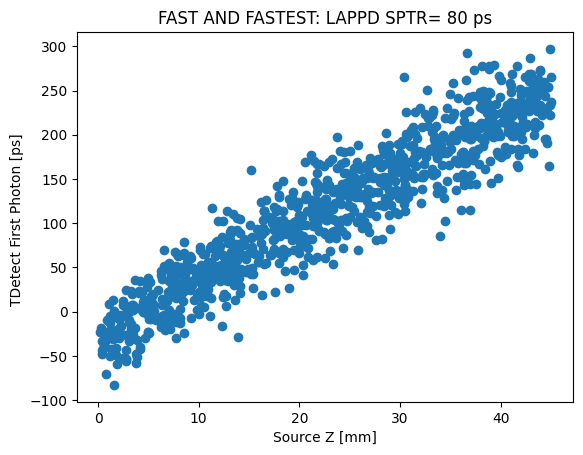

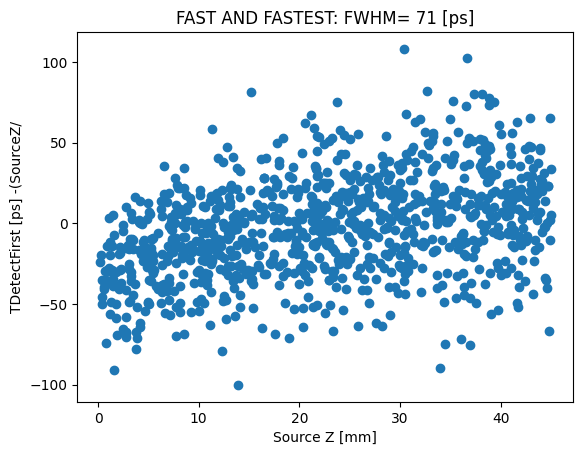

In [15]:
npTCollect=np.reshape(TCollect.numpy(),[NEvents,NPhotons])
ic(npTCollect.shape)
npSourceZ=np.reshape(SourceZ.numpy(),[NEvents,NPhotons])
ic(npSourceZ.shape)

#TCollectTMin=np.min(npTCollect,axis=1)
#ic(TCollectTMin.shape)

#ITCollectTMin=np.squeeze(TCollectTMin,axis=1)
#ITCollectTMin=np.amin(npTCollect,axis=1).astype(int)
#ic(ITCollectTMin.shape)
SourceZTMin=np.squeeze(npSourceZ[:,0])
ic(SourceZTMin.size)

for iEvent in range(NEvents):
  SourceZTMin[iEvent]=npSourceZ[iEvent][[iEvent] ]

ic(SourceZTMin.size)
plt.scatter(SourceZTMin,TMinDetect)
#plt.title("FAST AND FASTEST: MeanNSurviveSample= " + str(int(MeanNSurviveSample[0]+MeanNSurviveSample[1])) )
plt.title("FAST AND FASTEST: LAPPD SPTR= " + str(int(SPTRps))+ " ps" )

plt.xlabel("Source Z [mm]")
plt.ylabel("TDetect First Photon [ps] ")
plt.show()

TminErrorFWHM=2.35* np.std(TminError)
TminError=np.maximum(-200,TminError)
plt.scatter(SourceZTMin,TminError)
plt.title("FAST AND FASTEST: FWHM= " + str(int(np.floor(TminErrorFWHM))) + " [ps]" )
plt.xlabel("Source Z [mm]")
plt.ylabel("TDetectFirst [ps] -(SourceZ/")
plt.show()

Fast + Fastest with zero emission decay time (collection time only)

In [16]:
# Loop over photon emission species [Fastest,Fast,Slow]
AllDetectX=torch.zeros(3,NEvents,NPhotons)
AllDetectY=torch.zeros(3,NEvents,NPhotons)
AllDetectT=torch.zeros(3,NEvents,NPhotons)
AllSurviveReflect=torch.zeros(3,NEvents,NPhotons)
AllSurviveSample=torch.zeros(3,NEvents,NPhotons)
MeanNSurviveSample=np.zeros(3,dtype=float)

AllTMinDetect=TMax*torch.ones(3,NEvents)
AllTMinErrorFWHM=torch.zeros(3,NEvents)

photon_passes = {'Fastest',(Optics.PEs[0], Optics.IndexBaF2[0]),'Fast', (Optics.PEs[1], Optics.IndexBaF2[1]), 'Slow', (Optics.PEs[2], Optics.IndexBaF2[2])}
#
#for iPhotonPass in ['Fastest','Fast','Slow']:
#for iPhotonPass in [0:2]:
#
#for iPhotonPass in 'Fast'
#for iPhotonPass in [0,1,2]:
#
# FASTEST AND FAST COMPONENTS COMBINED
#
for iPhotonPass in [0,1]:
  PEs = Optics.PEs[iPhotonPass]
  Index = Optics.IndexBaF2[iPhotonPass]
  CMMPerPs = 0.3/Index
  #
  # Calculate critical angle for total internal reflection at interface
  SinThetaCriticalX=torch.tensor(Optics.IndexX/Index)
  SinThetaCriticalY=torch.tensor(Optics.IndexY/Index)
  PhotonOptics=Struct(['iPhotonPass',iPhotonPass],['PEs',PEs],['Index',Index],['CMMPerPs',CMMPerPs],['SinThetaCriticalX',SinThetaCriticalX],['SinThetaCriticalY',SinThetaCriticalY])
  #
  # Treat Reflectivity as independent of wavelength for the moment
  #  (i.e. take from Optics rather than PhotonOptics)
  ReflectX=Optics.ReflectX
  ReflectY=Optics.ReflectY
  ReflectZ=Optics.ReflectZ
  IndexX=Optics.IndexX
  IndexY=Optics.IndexY
  iPhotonPass=PhotonOptics.iPhotonPass
  NPEs=PhotonOptics.PEs
  CMMPerPs=PhotonOptics.CMMPerPs
  SinThetaCriticalX=PhotonOptics.SinThetaCriticalX
  SinThetaCriticalY=PhotonOptics.SinThetaCriticalY
  #
  # Random isotropic distributions for all photons, all events
  CosZSample=1.-2.*torch.rand(NEvents,NPhotons)
  torch.pi = torch.acos(torch.zeros(1)).item() * 2 # which is 3.1415927410125732
  PhiSample=2.*torch.pi*torch.rand(NEvents,NPhotons)
  #
  R = torch.sqrt(1.-torch.square(CosZSample))
  vX = CMMPerPs * R * torch.cos(PhiSample)
  vY = CMMPerPs * R * torch.sin(PhiSample)
  vZ = CMMPerPs * CosZSample
  SinTheta=CosZSample
  SinPhi=torch.sin(PhiSample)
  #
  #Clip to remove division by zero
  vZ=torch.where(torch.abs(vZ)>0.0000001,vZ,0.0000001)
  #
  # Calculate Photon Collection Time
  #SourceX, SourceY, SourceZ = Source(RunControl)
  TTop=torch.divide(((2.*DZ)-SourceZ),vZ)
  TBottom=torch.divide(((0.*DZ)-SourceZ),vZ)
  TCollect=torch.maximum(TTop,TBottom)
  vXCollect=SourceX +torch.multiply(vX,TCollect)
  vYCollect=SourceY +torch.multiply(vY,TCollect)
  TCollect=torch.maximum(torch.tensor(0.000001),TCollect)
  TCollect=torch.minimum(torch.tensor(TMax),TCollect)
  #
  # Calculate critical angle for total internal reflection at interface
  # Set up data structures for 6 different reflection type cases
  # depending on signs of VX, VY, snf vZ. Indices of medium and reflector then
  # provide critical angle for this reflection to be total internal
  #
  # Calculate critical angle for total internal reflection at interface
  SinThetaCriticalX=IndexX/Index
  SinThetaCriticalY=IndexY/Index
  #
  # Set up data structures for 6 different reflection type cases
  # depending on signs of VX, VY, snf vZ. Indices of medium and reflector then
  # provide critical angle for this reflection to be total internal
  #
  # Condition for total internal reflection off X or Y planes
  TIRX=torch.abs(SinTheta)>torch.abs(torch.tensor(SinThetaCriticalX))
  TIRY=torch.abs(SinTheta)>torch.abs(torch.tensor(SinThetaCriticalY))
  #
  #Distance between reflections
  DReflectX=torch.where(TIRX,dX,DX)
  DReflectY=torch.where(TIRY,dY,DY)
  #
  #Unfold hall of mirrors into virtual detector
  # Virtual detector collection ray lengths
  DVXCollect=torch.abs(vX)*TCollect
  DVYCollect=torch.abs(vY)*TCollect
  #
  # Find Collection coordinates in virtual detector
  VXDetect=SourceX + torch.multiply(TCollect,vX)
  VYDetect=SourceY + torch.multiply(TCollect,vY)
  #
  # Get offset of virtual detection position unit cell center
  OffsetX=torch.where(vX>0,torch.remainder(VXDetect+(DX/2),DReflectX)-(DReflectX/2),-torch.remainder(-VXDetect+(DReflectX/2),DReflectX)+(DReflectX/2))
  OffsetY=torch.where(vY>0,torch.remainder(VYDetect+(DY/2),DReflectY)-(DReflectY/2),-torch.remainder(-VYDetect+(DReflectY/2),DReflectY)+(DReflectY/2))
  #
  # Get offset of virtual detection point within unit cell
  XOffset=torch.where(VXDetect>0,DReflectX*torch.floor_divide(VXDetect,DReflectX),DReflectX*torch.floor_divide(-VXDetect,DReflectX))
  YOffset=torch.where(VYDetect>0,DReflectY*torch.floor_divide(VYDetect,DReflectY),DReflectY*torch.floor_divide(-VYDetect,DReflectY))
  #
  # Check whether first reflection is before being detected
  TFirstX=torch.empty(vX.shape,dtype=float)
  TFirstY=torch.empty(vY.shape,dtype=float)
  TFirstX=torch.where(torch.multiply(vX>0,~TIRX),torch.divide((DX/2.)-SourceX,vX),TFirstX)
  TFirstX=torch.where(torch.multiply(vX<0,~TIRX),torch.divide(SourceX-(DX/2.),vX),TFirstX)
  TFirstX=torch.where(torch.multiply(vX>0, TIRX),torch.divide((dX/2.)-(SourceX-XOffset),vX),TFirstX)
  TFirstX=torch.where(torch.multiply(vX<0, TIRX),torch.divide((XOffset-SourceX)-(dX/2.),vX),TFirstX)
  TFirstY=torch.where(torch.multiply(vY>0,~TIRY),torch.divide((DY/2.)-SourceY,vY),TFirstY)
  TFirstY=torch.where(torch.multiply(vY<0,~TIRY),torch.divide(SourceY-(DY/2.),vY),TFirstY)
  TFirstY=torch.where(torch.multiply(vY>0, TIRY),torch.divide((dY/2.)-(SourceY-YOffset),vY),TFirstY)
  TFirstY=torch.where(torch.multiply(vY<0, TIRY),torch.divide((YOffset-SourceY)-(dY/2.),vY),TFirstY)
  #
  # Number Reflections resulting in complete transits of unit cell
  NXWallToWall=torch.floor(DVXCollect/DReflectX)
  NYWallToWall=torch.floor(DVYCollect/DReflectY)
  #
  # Get time for traversal of all wall-to-wall reflection pairs
  TXWallToWall=torch.divide(torch.multiply(DReflectX,NXWallToWall),torch.abs(vX))
  TYWallToWall=torch.divide(torch.multiply(DReflectY,NYWallToWall),torch.abs(vY))
  #
  # Check time of first reflection
  NXWalltoWall=torch.where(TCollect<TFirstX,0,NXWallToWall)
  NYWallToWall=torch.where(TCollect<TFirstY,0,NYWallToWall)
  TLastX=torch.where(TCollect<TFirstX,0,TFirstX+TXWallToWall)
  TLastY=torch.where(TCollect<TFirstY,0,TFirstY+TYWallToWall)
  #
  # If there is no reflection before finst detection, decrement the Reflection counter
  NXWalltoWall=torch.where(TCollect<TFirstX,torch.maximum(torch.tensor([0]),NXWallToWall-1),NXWallToWall)
  NYWallToWall=torch.where(TCollect<TFirstY,torch.maximum(torch.tensor([0]),NYWallToWall-1),NYWallToWall)
  # If there is no reflection before final detection, decrement the Reflection counter
  NXWalltoWall=torch.where(TCollect<TLastX,torch.maximum(torch.tensor([0]),NXWallToWall-1),NXWallToWall)
  NYWallToWall=torch.where(TCollect<TLastY,torch.maximum(torch.tensor([0]),NYWallToWall-1),NYWallToWall)
  #
  # If there is a reflection before detection, increment the Reflection counter
  NXReflect=torch.where(TCollect<TFirstX,0,NXWallToWall+1)
  NYReflect=torch.where(TCollect<TFirstY,0,NYWallToWall+1)
  #
  # Get Reflection Survival Probability
  SurviveXReflect=torch.where(TIRX,1.,torch.pow(ReflectX,NXReflect))
  SurviveYReflect=torch.where(TIRY,1.,torch.pow(ReflectY,NYReflect))
  SurviveZReflect=torch.where(vZ>0,ReflectZ,1.)
  SurviveReflect=torch.multiply(torch.multiply(SurviveXReflect,SurviveYReflect),SurviveZReflect)
  #
  # Shift the TIR photons to their TIR unit cell, and allow for round-off error
  XDetect=OffsetX
  YDetect=OffsetY
  XDetect=torch.where(TIRX, XDetect+dX*(torch.floor_divide(SourceX+(DX/2),dX)-((DX/dX)/2)+(1/2)),XDetect)
  XDetect=torch.maximum(XDetect,-(DX/2.)+torch.tensor(0.00001))
  XDetect=torch.minimum(XDetect, (DX/2.)-torch.tensor(0.00001))
  YDetect=torch.where(TIRY, YDetect+dY*(torch.floor_divide(SourceY+(DY/2),dY)-((DY/dY)/2)+(1/2)),YDetect)
  YDetect=torch.maximum(YDetect,-(DY/2.)+torch.tensor(0.00001))
  YDetect=torch.minimum(YDetect, (DY/2.)-torch.tensor(0.00001))
  #
  # Optics.DecayT: [74, 791, 602000]
  ic(Optics.DecayT[iPhotonPass])
  TEmit=Optics.DecayT[iPhotonPass]*(-torch.log(torch.rand(NEvents,NPhotons)))
  ic(TEmit[0][0])
  #
  # TDETECT = TCOLLECT
  #
  #TDetect=TCollect
  TSensor=torch.normal(mean=torch.zeros(NEvents,NPhotons), std=SPTRsigma*torch.ones(NEvents,NPhotons))
  TDetect=TCollect+TSensor
  ic(TDetect[0][0])
  #
  AllDetectX[iPhotonPass,:,:]=XDetect
  AllDetectY[iPhotonPass,:,:]=YDetect
  AllDetectT[iPhotonPass,:,:]=TDetect
  AllSurviveReflect[iPhotonPass,:,:]=SurviveReflect
  #
  # NPEs = Optics.PEs[iPhotonPass]
  ic(NPEs)
  SurviveSample=torch.zeros(NEvents,NPhotons)
  ScaledSurvival=SurviveReflect*(NPEs/NPhotons)
  ISurvive=ScaledSurvival>torch.rand(NEvents,NPhotons)
  SampleT=torch.where(ISurvive,TDetect,TMax)
  NSurviveSample=torch.sum(ISurvive,dim=1)
  ic(NSurviveSample[0:9])
  AllSurviveSample[iPhotonPass,:,:]=ISurvive
  #
  SampleMinT=np.where(ISurvive,TDetect,TMax)
  ic(SampleMinT.shape)
  TMinDetect=np.min(SampleMinT,axis=1)
  ic(TMinDetect.shape)
  ic(TMinDetect[0])
  ic(TCollect[0])
  AllTMinDetect[iPhotonPass,:]=torch.tensor(TMinDetect)
  MeanNSurviveSample[iPhotonPass]=(NSurviveSample.numpy()).mean()

ic(AllTMinDetect.size())
TMinDetect=np.min(AllTMinDetect.numpy(),axis=0)
TminError=TMinDetect-(SourceZTMin/CMMPerPs)
TminErrorFWHM=2.35* np.std(TminError)

ic| Optics.DecayT[iPhotonPass]: 74
ic| TEmit[0][0]: tensor(81.8067)
ic| TDetect[0][0]: tensor(191.9404)
ic| NPEs: 42
ic| NSurviveSample[0:9]: tensor([26, 26, 26, 29, 25, 23, 23, 25, 29])
ic| SampleMinT.shape: (1000, 10000)
ic| TMinDetect.shape: (1000,)
ic| TMinDetect[0]: 85.14094
ic| TCollect[0]: tensor([ 198.3296,  105.6823,  452.0995,  ..., 1000.0000,  428.3085,
                          441.8120])
ic| Optics.DecayT[iPhotonPass]: 791
ic| TEmit[0][0]: tensor(704.3256)
ic| TDetect[0][0]: tensor(274.0311)
ic| NPEs: 171
ic| NSurviveSample[0:9]: tensor([103, 126,  93, 119, 119, 113, 118, 105, 111])
ic| SampleMinT.shape: (1000, 10000)
ic| TMinDetect.shape: (1000,)
ic| TMinDetect[0]: 42.82754
ic| TCollect[0]: tensor([ 308.8017, 1000.0000,  143.9207,  ...,  312.1873,  250.4782,
                          396.1882])
ic| AllTMinDetect.size(): torch.Size([3, 1000])


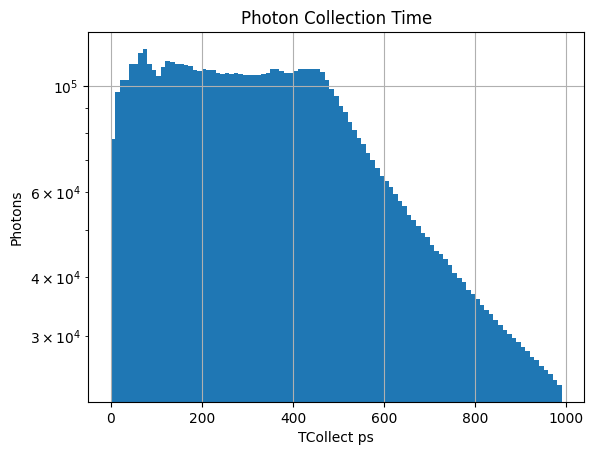

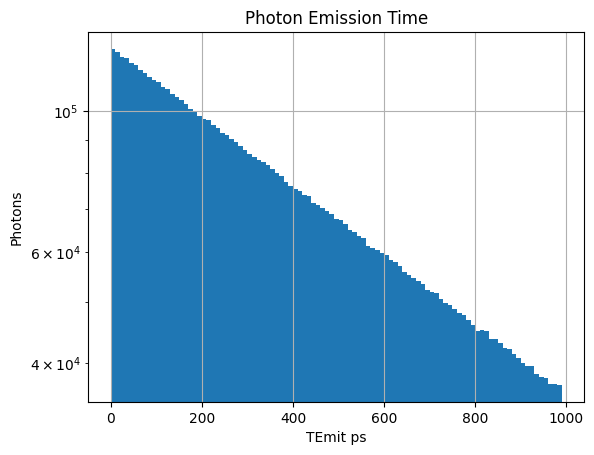

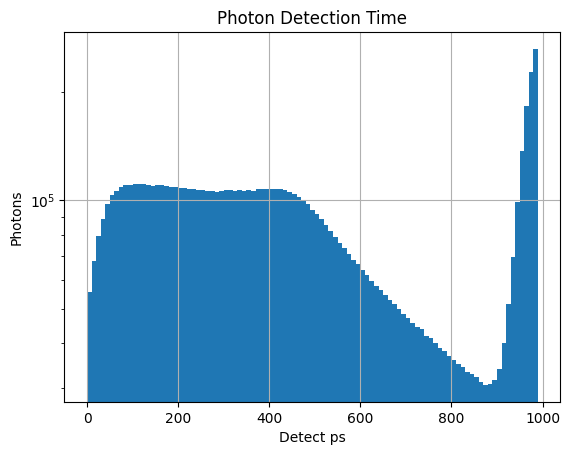

In [17]:
HValues=(TCollect.flatten()).numpy()
HValues=HValues[HValues<1000]
HBins=np.arange(0,1000,10)

plt.hist(HValues, bins=HBins)
plt.xlabel('TCollect ps')
plt.ylabel('Photons')
plt.title('Photon Collection Time')
plt.grid()
plt.yscale('log')
plt.show()

HValues=(TEmit.flatten()).numpy()
HValues=HValues[HValues<1000]
HBins=np.arange(0,1000,10)

plt.hist(HValues, bins=HBins)
plt.xlabel('TEmit ps')
plt.ylabel('Photons')
plt.title('Photon Emission Time')
plt.grid()
plt.yscale('log')
plt.show()

HValues=(TDetect.flatten()).numpy()
HValues=HValues[HValues<1000]
HBins=np.arange(0,1000,10)

plt.hist(HValues, bins=HBins)
plt.xlabel('Detect ps')
plt.ylabel('Photons')
plt.title('Photon Detection Time')
plt.grid()
plt.yscale('log')
plt.show()

Plot mean survival probability as a function of ZSource

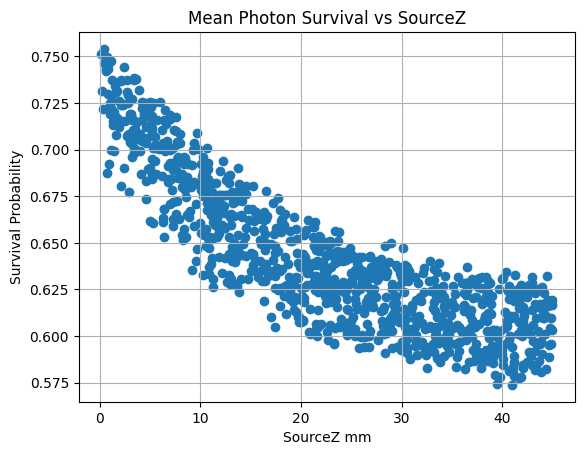

In [18]:
MeanSurviveReflect=torch.mean(SurviveReflect,1)
plt.scatter(SourceZ[:,0],MeanSurviveReflect)
plt.xlabel('SourceZ mm')
plt.ylabel('Survival Probability')
plt.title('Mean Photon Survival vs SourceZ')
plt.grid()

Perform parallel calculations for all the photon list entries for all the events, and print out the first event photon list attributes for a specified sample photon [debugging tool]

If RegularZ, display histograms of by IT of events varying as a function of Z



Form digitized IX and IY outputs, and generate survival-weighted scatterplots from random photons from the ZPencil events


ic| dZ: 3.0
ic| DZ: 45.0
ic| thisDetectIXY: array([12.,  2., 29., ..., 25., 70., 71.], dtype=float32)
ic| thisSurviveReflect: tensor([0.6561, 0.3487, 0.8100,  ..., 0.6561, 0.8100, 0.9000])
ic| aMaxThisDetectXY: 16
<ipython-input-19-697a9988cf0e>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  SurviveMaxXY[thisEvent,:]=torch.tensor(thisSurviveReflect)
ic| RandTest.shape: (10000000,)
ic| RandSample.shape: (10000000,)
ic| ISample.size: 995


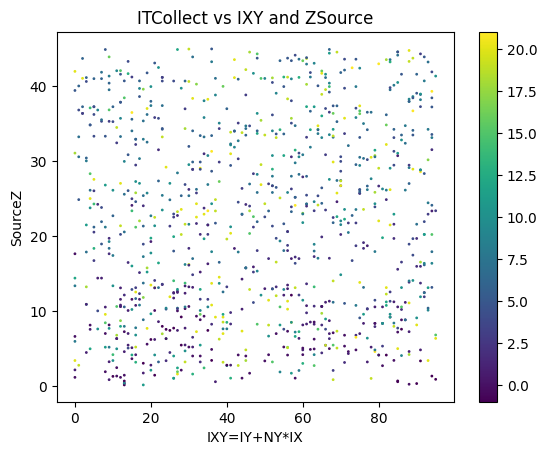

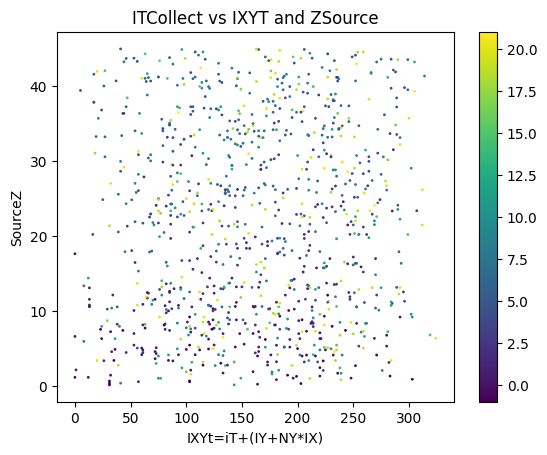

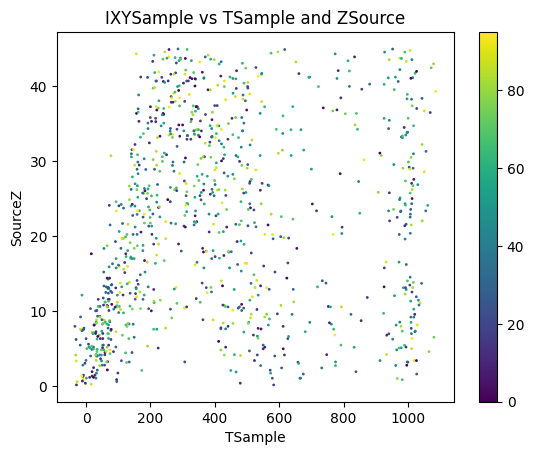

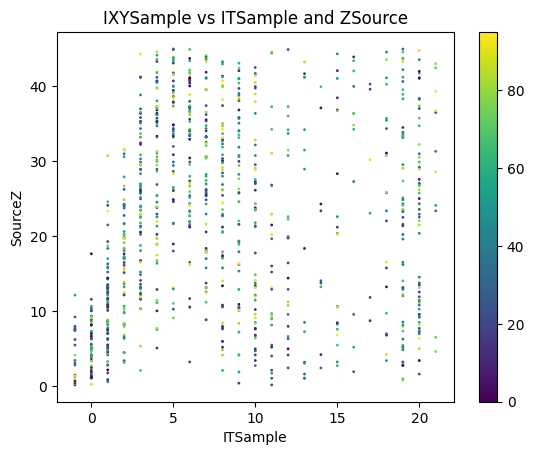

In [19]:

ic(dZ)
ic(DZ)
DetectNZ=torch.tensor(int(DZ/dZ))
DetectNT=torch.tensor(int(1000/50))
SurviveMaxXY=torch.zeros(NEvents,NPhotons)
#
for thisEvent in range(0,NEvents):
  thisXDetect=torch.floor_divide(XDetect[thisEvent,:]+(DX/2.),dX)
  thisIXDetect=thisXDetect.numpy()
  thisYDetect=torch.floor_divide(YDetect[thisEvent,:]+(DY/2.),dY)
  thisIYDetect=thisYDetect.numpy()
  thisITDetect=torch.floor_divide(TDetect[thisEvent,:],50)
  thisITDetect=thisITDetect.numpy()
  thisSurviveReflect=SurviveReflect[thisEvent,:]
  thisDetectIXY=thisIXDetect+(DetectNX*thisIYDetect)
  aMaxThisDetectXY=np.argmax(thisDetectIXY)
  if(thisEvent==0):
    ic(thisDetectIXY)
    ic(thisSurviveReflect)
    ic(aMaxThisDetectXY)
  aMaxTest=torch.tensor(aMaxThisDetectXY==thisDetectIXY)
  SurviveMaxXY[thisEvent,:]=torch.tensor(thisSurviveReflect)

NSample=1000
FlatSurviveReflect=(SurviveMaxXY.flatten().numpy())
TotalSurviveReflect=FlatSurviveReflect.sum()
RandTest=(NSample/TotalSurviveReflect)*FlatSurviveReflect
ic(RandTest.shape)
#
rng = np.random.default_rng()
# Generate random floats uniformly distributed over the range [0, 1)
RandSample=rng.random(RandTest.size)
ic(RandSample.shape)
ISample=np.asarray(np.nonzero(RandSample<RandTest))
ic(ISample.size)

IX=(torch.floor_divide(XDetect+(DX/2.),dX).flatten()).numpy()
IXSample=IX[ISample]
IY=(torch.floor_divide(YDetect+(DY/2.),dY).flatten()).numpy()
IYSample=IY[ISample]
IXYSample=IYSample+(DetectNY*IXSample)
TMax=1000
dT=50
DetectNT=int(TMax/dT)
IT=(torch.floor_divide(TDetect,dT).flatten()).numpy()
ITSample=IT[ISample]
flatTDetect=TDetect.flatten().numpy()
TSample=flatTDetect[ISample]
IXYTSample=ITSample+(DetectNT*IYSample+(DetectNY*IXSample))
flatSourceZ=SourceZ.flatten().numpy()
ZSourceSample=flatSourceZ[ISample]

plt.scatter(IXYSample,ZSourceSample,c=ITSample,s=1)
plt.title('ITCollect vs IXY and ZSource' )
plt.xlabel('IXY=IY+NY*IX')
plt.ylabel('SourceZ')
plt.colorbar()
plt.show()

plt.scatter(IXYTSample,ZSourceSample,c=ITSample,s=1)
plt.title('ITCollect vs IXYT and ZSource' )
plt.xlabel('IXYt=iT+(IY+NY*IX)')
plt.ylabel('SourceZ')
plt.colorbar()
plt.show()

plt.scatter(TSample,ZSourceSample,c=IXYSample,s=1)
plt.title('IXYSample vs TSample and ZSource' )
plt.xlabel('TSample')
plt.ylabel('SourceZ')
plt.colorbar()
plt.show()


plt.scatter(ITSample,ZSourceSample,c=IXYSample,s=1)
plt.title('IXYSample vs ITSample and ZSource' )
plt.xlabel('ITSample')
plt.ylabel('SourceZ')
plt.colorbar()
plt.show()

Form digitized IX and IY outputs, then generate and store survival-weighted 2D histograms while looping over events.

Display the digitized IXY histogram for the sum of all events

ic| Detect2Dbins: (array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
                   array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]))
ic| DetectXY.size(): torch.Size([1000, 12, 8])
ic| thisIXDetect.shape: (10000,)
ic| thisIYDetect.shape: (10000,)
ic| thisSurviveReflect.shape: (10000,)
ic| DetectXY.shape: torch.Size([1000, 12, 8])
ic| DetectXY0.shape: (12, 8)
<ipython-input-20-75be3436c16d>:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!


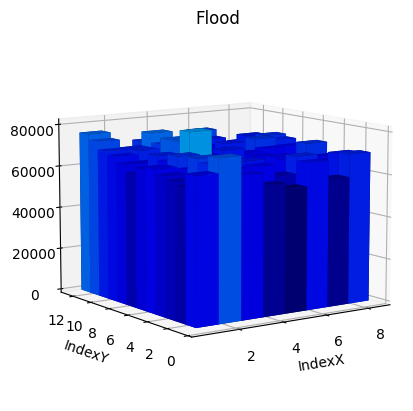

In [20]:
xedges=np.arange(0,1+DetectNX,1)
yedges=np.arange(0,1+DetectNY,1)
Detect2Dbins=(xedges,yedges)
ic(Detect2Dbins)
DetectXY=torch.zeros(NEvents,DetectNY,DetectNX)
ic(DetectXY.size())
#
for thisEvent in range(0,NEvents):
  thisXDetect=torch.floor_divide(XDetect[thisEvent,:]+(DX/2.),dX)
  thisIXDetect=thisXDetect.numpy()
  if (thisEvent==0):
     ic(thisIXDetect.shape)
  thisIYDetect=torch.floor_divide(YDetect[thisEvent,:]+(DY/2.),dY)
  thisIYDetect=thisIYDetect.numpy()
  if (thisEvent==0):
    ic(thisIYDetect.shape)
  thisSurviveReflect=SurviveReflect[thisEvent,:].numpy()
  if (thisEvent==0):
    ic(thisSurviveReflect.shape)
  thisDetectXY, thisXedge, thisYedge= np.histogram2d(thisIXDetect,thisIYDetect,bins=Detect2Dbins,weights=thisSurviveReflect)
  DetectXY[thisEvent,:,:]=torch.transpose(torch.tensor(thisDetectXY),0,1)

ic(DetectXY.shape)
DetectXY0=torch.sum(DetectXY,0)
DetectXY0=DetectXY0.numpy()
ic(DetectXY0.shape)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
#ax = fig.add_subplot(132, title='DetectH', aspect='equal')
xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])

xpos = xpos.flatten()/2.
ypos = ypos.flatten()/2.
zpos = np.zeros_like (xpos)

Hdx = xedges [1] - xedges [0]
Hdy = yedges [1] - yedges [0]
Hdz = DetectXY0.flatten()

from matplotlib import cm
cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!
#plt.colormaps['jet']
max_height = np.max(Hdz)   # get range of colorbars so we can normalize
min_height = np.min(Hdz)
# scale each z to [0,1], and get their rgb values
rgba = [cmap((k-min_height)/max_height) for k in Hdz]


ax.bar3d(xpos, ypos, zpos, Hdx, Hdy, Hdz, color=rgba, zsort='average')
plt.xlabel("IndexX")
plt.ylabel("IndexY")
plt.title('Flood')
ax.view_init(elev=10, azim=235, roll=0)
#plt.savefig("Your_title_goes_here")
plt.show()

Form digitized IZ and IT outputs, then generate and store survival-weighted 2D histograms while looping over events.

Display the digitized IZT histogram for the sum of all events

ic| Detect2Dbins: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
                         17, 18, 19, 20]),
                   array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]))
ic| DetectZT.size(): torch.Size([1000, 15, 20])
ic| DetectZT.shape: torch.Size([1000, 15, 20])
ic| DetectZT0.shape: (15, 20)
<ipython-input-21-aa83dc279c42>:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!


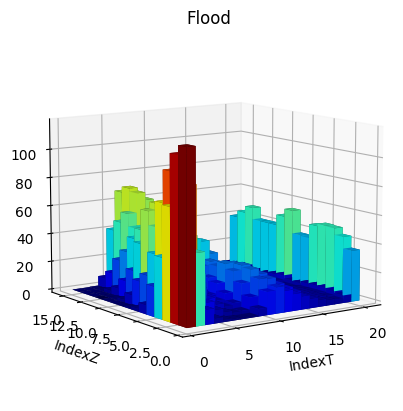

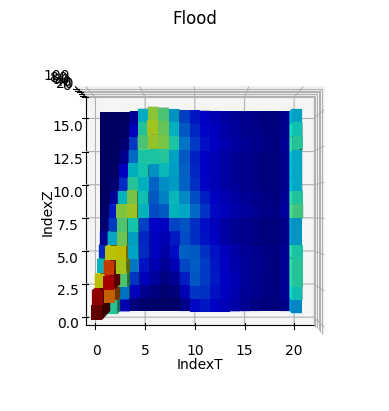

In [21]:
xedges=np.arange(0,1+DetectNT,1)
yedges=np.arange(0,1+DetectNZ,1)
Detect2Dbins=(xedges,yedges)
ic(Detect2Dbins)
DetectZT=torch.zeros(NEvents,DetectNZ,DetectNT)
ic(DetectZT.size())
#
for thisEvent in range(0,NEvents):
  thisIZSource=torch.floor_divide(SourceZ[thisEvent,:],dZ)
  thisIZSource=thisIZSource.numpy()
  thisITDetect=torch.floor_divide(TDetect[thisEvent,:],dT)
  thisITDetect=thisITDetect.numpy()
  thisSurviveReflect=SurviveReflect[thisEvent,:].numpy()
  thisDetectZT, thisXedge, thisYedge= np.histogram2d(thisITDetect,thisIZSource,bins=Detect2Dbins,weights=thisSurviveReflect)
  thisDetectZT=thisDetectZT.T
  DetectZT[thisEvent,:,:]=torch.tensor(thisDetectZT)

ic(DetectZT.shape)
DetectZT0=torch.mean(DetectZT,0)
DetectZT0=DetectZT0.numpy()
ic(DetectZT0.shape)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
#ax = fig.add_subplot(132, title='DetectH', aspect='equal')
xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])

xpos = xpos.flatten()/2.
ypos = ypos.flatten()/2.
zpos = np.zeros_like (xpos)

Hdx = xedges [1] - xedges [0]
Hdy = yedges [1] - yedges [0]
Hdz = DetectZT0.flatten()

from matplotlib import cm
cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!
#plt.colormaps['jet']
max_height = np.max(Hdz)   # get range of colorbars so we can normalize
min_height = np.min(Hdz)
# scale each z to [0,1], and get their rgb values
rgba = [cmap((k-min_height)/max_height) for k in Hdz]


ax.bar3d(xpos, ypos, zpos, Hdx, Hdy, Hdz, color=rgba, zsort='average')
plt.xlabel("IndexT")
plt.ylabel("IndexZ")
plt.title('Flood')
ax.view_init(elev=10, azim=235, roll=0)
#plt.savefig("Your_title_goes_here")
plt.show()

ax = plt.figure().add_subplot(projection='3d')
ax.bar3d(xpos, ypos, zpos, Hdx, Hdy, Hdz, color=rgba, zsort='average')
plt.xlabel("IndexT")
plt.ylabel("IndexZ")
plt.title('Flood')
ax.view_init(elev=90, azim=-90, roll=0)
#plt.savefig("Your_title_goes_here")
plt.show()

Form digitized IX and IT outputs, then generate and store survival-weighted 2D histograms while looping over events.

Display the digitized IXT histogram for the sum of all events

ic| Detect2Dbins: (array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
                   array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
                         17, 18, 19, 20]))
ic| DetectXT.size(): torch.Size([1000, 20, 8])
ic| thisIXDetect.shape: (10000,)
ic| thisITDetect.shape: (10000,)
ic| thisSurviveReflect.shape: (10000,)
ic| DetectXT.shape: torch.Size([1000, 20, 8])
ic| DetectXT0.shape: (20, 8)
<ipython-input-22-c8faf62de9f6>:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!


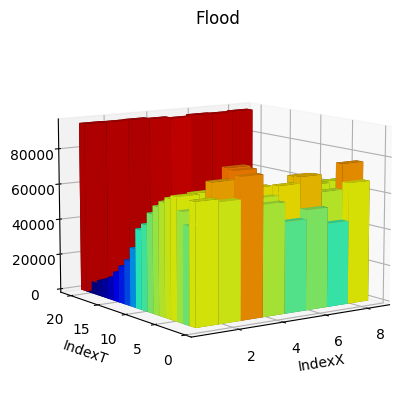

In [22]:
xedges=np.arange(0,1+DetectNX,1)
dT=50
DetectNT=int(1000/50)
yedges=np.arange(0,1+DetectNT,1)
Detect2Dbins=(xedges,yedges)
ic(Detect2Dbins)
DetectNT=torch.tensor(int(1000/50))
DetectXT=torch.zeros(NEvents,DetectNT,DetectNX)
ic(DetectXT.size())
#
for thisEvent in range(0,NEvents):
  thisXDetect=torch.floor_divide(XDetect[thisEvent,:]+(DX/2.),dX)
  thisIXDetect=thisXDetect.numpy()
  if (thisEvent==0):
     ic(thisIXDetect.shape)
  thisITDetect=torch.floor_divide(TCollect[thisEvent,:],50)
  thisITDetect=thisITDetect.numpy()
  if (thisEvent==0):
    ic(thisITDetect.shape)
  thisSurviveReflect=SurviveReflect[thisEvent,:].numpy()
  if (thisEvent==0):
    ic(thisSurviveReflect.shape)
  thisDetectXT, thisXedge, thisTedge= np.histogram2d(thisIXDetect,thisITDetect,bins=Detect2Dbins,weights=thisSurviveReflect)
  DetectXT[thisEvent,:,:]=torch.transpose(torch.tensor(thisDetectXT),0,1)

ic(DetectXT.shape)
DetectXT0=torch.sum(DetectXT,0)
DetectXT0=DetectXT0.numpy()
ic(DetectXT0.shape)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
#ax = fig.add_subplot(132, title='DetectH', aspect='equal')
xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])

xpos = xpos.flatten()/2.
ypos = ypos.flatten()/2.
zpos = np.zeros_like (xpos)

Hdx = xedges [1] - xedges [0]
Hdy = yedges [1] - yedges [0]
Hdz = DetectXT0.flatten()

from matplotlib import cm
cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!
#plt.colormaps['jet']
max_height = np.max(Hdz)   # get range of colorbars so we can normalize
min_height = np.min(Hdz)
# scale each z to [0,1], and get their rgb values
rgba = [cmap((k-min_height)/max_height) for k in Hdz]


ax.bar3d(xpos, ypos, zpos, Hdx, Hdy, Hdz, color=rgba, zsort='average')
plt.xlabel("IndexX")
plt.ylabel("IndexT")
plt.title('Flood')
ax.view_init(elev=10, azim=235, roll=0)
#plt.savefig("Your_title_goes_here")
plt.show()

Form digitized IY and IT outputs, then generate and store survival-weighted 2D histograms while looping over events.

Display the digitized YT histogram for the sum of all events

ic| Detect2Dbins: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
                   array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
                         17, 18, 19, 20]))
ic| DetectYT.size(): torch.Size([1000, 20, 12])
ic| thisIYDetect.shape: (10000,)
ic| thisITDetect.shape: (10000,)
ic| thisSurviveReflect.shape: (10000,)
ic| DetectYT.shape: torch.Size([1000, 20, 12])
ic| DetectYT0.shape: (20, 12)
<ipython-input-23-680bc069d87f>:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!


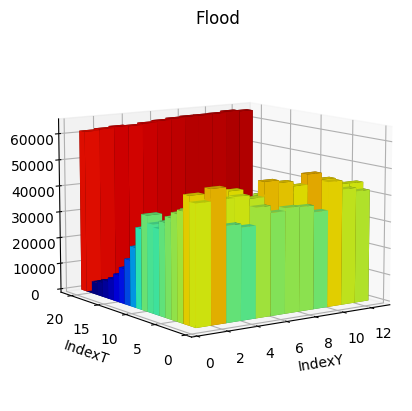

In [23]:
xedges=np.arange(0,1+DetectNY,1)
dT=50
DetectNT=int(1000/50)
yedges=np.arange(0,1+DetectNT,1)
Detect2Dbins=(xedges,yedges)
ic(Detect2Dbins)
DetectNT=torch.tensor(int(1000/50))
DetectYT=torch.zeros(NEvents,DetectNT,DetectNY)
ic(DetectYT.size())
#
for thisEvent in range(0,NEvents):
  thisYDetect=torch.floor_divide(YDetect[thisEvent,:]+(DY/2.),dY)
  thisIYDetect=thisYDetect.numpy()
  if (thisEvent==0):
     ic(thisIYDetect.shape)
  thisITDetect=torch.floor_divide(TCollect[thisEvent,:],50)
  thisITDetect=thisITDetect.numpy()
  if (thisEvent==0):
    ic(thisITDetect.shape)
  thisSurviveReflect=SurviveReflect[thisEvent,:].numpy()
  if (thisEvent==0):
    ic(thisSurviveReflect.shape)
  thisDetectYT, thisXedge, thisTedge= np.histogram2d(thisIYDetect,thisITDetect,bins=Detect2Dbins,weights=thisSurviveReflect)
  DetectYT[thisEvent,:,:]=torch.transpose(torch.tensor(thisDetectYT),0,1)

ic(DetectYT.shape)
DetectYT0=torch.sum(DetectYT,0)
DetectYT0=DetectYT0.numpy()
ic(DetectYT0.shape)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
#ax = fig.add_subplot(132, title='DetectH', aspect='equal')
xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])

xpos = xpos.flatten()/2.
ypos = ypos.flatten()/2.
zpos = np.zeros_like (xpos)

Hdx = xedges [1] - xedges [0]
Hdy = yedges [1] - yedges [0]
Hdz = DetectYT0.flatten()

from matplotlib import cm
cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!
#plt.colormaps['jet']
max_height = np.max(Hdz)   # get range of colorbars so we can normalize
min_height = np.min(Hdz)
# scale each z to [0,1], and get their rgb values
rgba = [cmap((k-min_height)/max_height) for k in Hdz]


ax.bar3d(xpos, ypos, zpos, Hdx, Hdy, Hdz, color=rgba, zsort='average')
plt.xlabel("IndexY")
plt.ylabel("IndexT")
plt.title('Flood')
ax.view_init(elev=10, azim=235, roll=0)
#plt.savefig("Your_title_goes_here")
plt.show()

Looping over all events, generate a set of histograms for the XYT data, and store them.

Generate and display a 2D display from XY,T for the sum of all events.

ic| DetectXYT.size(): torch.Size([1000, 20, 96])
ic| thisIXDetect.shape: (10000,)
ic| thisIYDetect.shape: (10000,)
ic| thisITDetect.shape: (10000,)
ic| thisSurviveReflect.shape: (10000,)
ic| DetectXYT0.shape: (20, 96)
ic| xedges.shape: (97,)
ic| yedges.shape: (21,)
ic| HX.shape: (21, 97)
ic| HY.shape: (21, 97)
ic| DetectXYT0.shape: (20, 96)


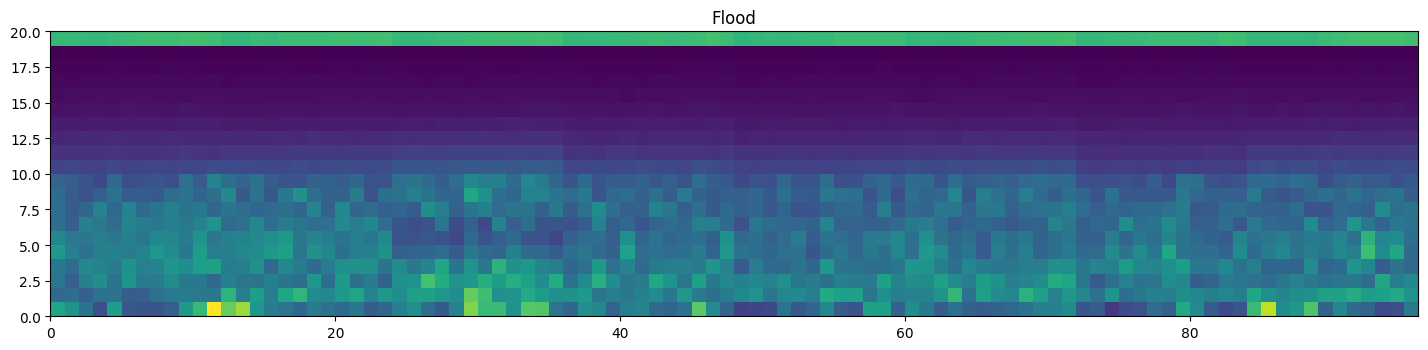

ic| EventData.shape: (8, 12, 20)
ic| EventData[:,5,2]: array([3733.1099 , 6216.9033 , 4972.746  , 4795.7837 , 2043.3885 ,
                             1233.5045 ,  676.57184,  518.3856 ], dtype=float32)


array([3733.1099 , 6216.9033 , 4972.746  , 4795.7837 , 2043.3885 ,
       1233.5045 ,  676.57184,  518.3856 ], dtype=float32)

In [24]:
DetectXYT=torch.zeros(NEvents,DetectNT,DetectNX*DetectNY)
ic(DetectXYT.size())
xedges=np.arange(0,1+DetectNX*DetectNY,1)
yedges=np.arange(0,1+DetectNT,1)
Detect2Dbins=(xedges,yedges)

for thisEvent in range(0,NEvents):
  thisXDetect=torch.floor_divide(XDetect[thisEvent,:]+(DX/2.),dX)
  thisIXDetect=thisXDetect.numpy()
  if (thisEvent==0):
     ic(thisIXDetect.shape)
  thisYDetect=torch.floor_divide(YDetect[thisEvent,:]+(DY/2.),dY)
  thisIYDetect=thisYDetect.numpy()
  if (thisEvent==0):
     ic(thisIYDetect.shape)
  thisIXYDetect=thisIYDetect+(DetectNY*thisIXDetect)
  #
  thisITDetect=torch.floor_divide(TCollect[thisEvent,:],dT)
  thisITDetect=thisITDetect.numpy()
  if (thisEvent==0):
    ic(thisITDetect.shape)
  thisSurviveReflect=SurviveReflect[thisEvent,:].numpy()
  if (thisEvent==0):
    ic(thisSurviveReflect.shape)
  thisDetectXYT, thisXedge, thisTedge= np.histogram2d(thisIXYDetect,thisITDetect,bins=Detect2Dbins,weights=thisSurviveReflect)
  DetectXYT[thisEvent,:,:]=torch.transpose(torch.tensor(thisDetectXYT),0,1)

DetectXYT0=(torch.sum(DetectXYT,0).numpy()).reshape([DetectNT,DetectNX*DetectNY])

ic(DetectXYT0.shape)

fig = plt.figure(figsize=(60, 30))

ThisTitle='Flood'

ax = fig.add_subplot(132, title=ThisTitle,
        aspect='equal')
ic(xedges.shape)
ic(yedges.shape)
HX, HY = np.meshgrid(xedges, yedges)
ic(HX.shape)
ic(HY.shape)
ic(DetectXYT0.shape)

ax.pcolormesh(HX, HY, DetectXYT0)
plt.show()

EventData=np.reshape(DetectXYT0,[DetectNX,DetectNY,DetectNT])
ic(EventData.shape)
ic(EventData[:,5,2])

Report mean photon survival probability for the first event.

Display histogram of Reflection Survival Likelihood for the photons in the first even.

Also display histogram of Reflection Survival-weighted photon collection times

Looping over all events, generate output Data tensor for each event

Data.size=[NEvents,DetectNX,DetectNY,DetectNT)

Digitized Detector Indices: [IT,IX,IY]

Digitized Z Source Position: [IZ]

Data [NT=20,NX=8,NY=12] and dT=50 [ps] currently

In [25]:
ic(NPhotons)
ic(NEvents)
#
# Digitize with perfect modulation transfer function (MTF) and histogram
IEvent=torch.reshape(torch.arange(0,NEvents).repeat(NPhotons),[NEvents, NPhotons])
#ic(IEvent.size())
#ic(IEvent[0][0])
#ic(IEvent[0][1])
#ic(IEvent[1][0])

IXDetect=(torch.floor_divide((DX/2.)+XDetect,dX)).int()
ic(IXDetect.size())
IYDetect=(torch.floor_divide((DY/2.)+YDetect,dY)).int()
dZ=3.
IZDetect=(torch.floor_divide(SourceZ,dZ)).int()
ITDetect=(torch.floor_divide(TCollect,50)).int()
DetectNT=torch.tensor(int(1000/50))

NHBins_Htyx=((DetectNT*DetectNY*DetectNX).int()).numpy()
NHBins_Hty=((DetectNT*DetectNY).int()).numpy()
DetectNT=int(1000/50)
NHBins_Htx=int(DetectNT*DetectNX)
NHBins_Hyx=int(DetectNY*DetectNX)
NHBins_Ht=DetectNT
NHBins_Hy=DetectNY
NHBins_Hx=DetectNX
#
xedges=np.arange(0,1+DetectNT,1)
yedges=np.arange(0,1+DetectNY,1)
HBins_Hty=(xedges,yedges)
xedges=np.arange(0,1+DetectNT,1)
yedges=np.arange(0,1+DetectNX,1)
HBins_Htx=(xedges,yedges)
xedges=np.arange(0,1+DetectNY,1)
yedges=np.arange(0,1+DetectNX,1)
HBins_Hyx=(xedges,yedges)

#IDetect=ITDetect+DetectNT*(IYDetect+DetectNY*(IXDetect+DetectNX*IEvent))
Data=torch.zeros(NEvents,DetectNX,DetectNY,DetectNT)
ic(Data.size())

for iEvent in range(0,NEvents):
  #Collect floating point data for this event
  thisTDetect=ITDetect[iEvent,:]
  thisYDetect=IYDetect[iEvent,:]
  thisXDetect=IXDetect[iEvent,:]
  #
  # Form index for histogramming
  #thisDetect=(thisTDetect+DetectNT*(thisYDetect+DetectNY*thisXDetect))
  #thisDetect1=thisTDetect
  #thisDetect2=np.add(thisYDetect,DetectNY*thisDetect1)
  #thisDetect_tyx=np.add(thisXDetect,DetectNX*thisDetect2)
  thisDetect1=thisXDetect
  thisDetect2=np.add(thisYDetect,DetectNY*thisDetect1)
  thisDetect_tyx=np.add(thisTDetect,DetectNT*thisDetect2)
  #
  thisDetect_ty=np.add(thisTDetect,DetectNT*thisYDetect)
  thisDetect_tx=np.add(thisTDetect,DetectNT*thisXDetect)
  thisDetect_yx=np.add(thisYDetect,DetectNY*thisXDetect)
  #
  thisSurviveReflect=(SurviveReflect[iEvent,:])
  thisSurviveReflect=thisSurviveReflect.numpy()
  Detect_Htyx, Htyx_edge = np.histogram(thisDetect_tyx, bins=NHBins_Htyx, weights=thisSurviveReflect)
  #
  thisData=np.reshape(Detect_Htyx,[DetectNT,DetectNY,DetectNX])
  Data[iEvent,:,:,:]=torch.tensor(np.reshape(thisData,[DetectNX,DetectNY,DetectNT]))

ic(Data.size())
print("Data.size=[NEvents,NX,NY,NT]")

ic| NPhotons: 10000
ic| NEvents: 1000
ic| IXDetect.size(): torch.Size([1000, 10000])
ic| Data.size(): torch.Size([1000, 8, 12, 20])
ic| Data.size(): torch.Size([1000, 8, 12, 20])


Data.size=[NEvents,NX,NY,NT]


Form digitized IX, IY, IZ and iT outputs, then generate and store survival-weighted 2D histograms while looping over events.

Display the digitized IZT histogram for the sum of all events

ic| Detect2Dbins: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
                   array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
                         17, 18, 19, 20]))
ic| DetectYT.size(): torch.Size([1000, 20, 12])
ic| thisIYDetect.shape: (10000,)
ic| thisITDetect.shape: (10000,)
ic| thisSurviveReflect.shape: (10000,)
ic| DetectYT.shape: torch.Size([1000, 20, 12])
ic| DetectYT0.shape: (20, 12)
<ipython-input-26-b2dfd699f3d3>:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!


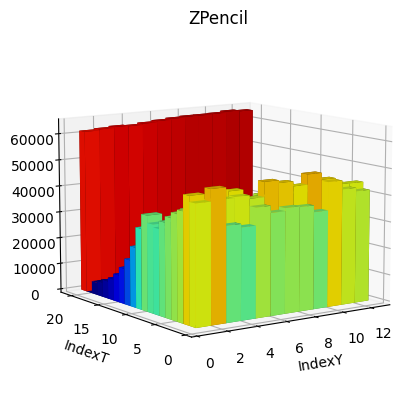

In [26]:
xedges=np.arange(0,1+DetectNY,1)
dT=50
DetectNT=int(1000/50)
yedges=np.arange(0,1+DetectNT,1)
Detect2Dbins=(xedges,yedges)
ic(Detect2Dbins)
DetectNT=torch.tensor(int(1000/50))
DetectYT=torch.zeros(NEvents,DetectNT,DetectNY)
ic(DetectYT.size())
#
for thisEvent in range(0,NEvents):
  thisYDetect=torch.floor_divide(YDetect[thisEvent,:]+(DY/2.),dY)
  thisIYDetect=thisYDetect.numpy()
  if (thisEvent==0):
     ic(thisIYDetect.shape)
  thisITDetect=torch.floor_divide(TCollect[thisEvent,:],50)
  thisITDetect=thisITDetect.numpy()
  if (thisEvent==0):
    ic(thisITDetect.shape)
  thisSurviveReflect=SurviveReflect[thisEvent,:].numpy()
  if (thisEvent==0):
    ic(thisSurviveReflect.shape)
  thisDetectYT, thisXedge, thisTedge= np.histogram2d(thisIYDetect,thisITDetect,bins=Detect2Dbins,weights=thisSurviveReflect)
  DetectYT[thisEvent,:,:]=torch.transpose(torch.tensor(thisDetectYT),0,1)

ic(DetectYT.shape)
DetectYT0=torch.sum(DetectYT,0)
DetectYT0=DetectYT0.numpy()
ic(DetectYT0.shape)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
#ax = fig.add_subplot(132, title='DetectH', aspect='equal')
xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])

xpos = xpos.flatten()/2.
ypos = ypos.flatten()/2.
zpos = np.zeros_like (xpos)

Hdx = xedges [1] - xedges [0]
Hdy = yedges [1] - yedges [0]
Hdz = DetectYT0.flatten()

from matplotlib import cm
cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!
#plt.colormaps['jet']
max_height = np.max(Hdz)   # get range of colorbars so we can normalize
min_height = np.min(Hdz)
# scale each z to [0,1], and get their rgb values
rgba = [cmap((k-min_height)/max_height) for k in Hdz]


ax.bar3d(xpos, ypos, zpos, Hdx, Hdy, Hdz, color=rgba, zsort='average')
plt.xlabel("IndexY")
plt.ylabel("IndexT")
plt.title('ZPencil')
ax.view_init(elev=10, azim=235, roll=0)
#plt.savefig("Your_title_goes_here")
plt.show()

In [27]:
print("NPEs=",NPEs)
#print("Index=",Index)
# Calculate critical angle for total internal reflection at interface
SinThetaCriticalX=IndexX/Index
#print("SinThetaCriticalX=",SinThetaCriticalX)
SinThetaCriticalY=IndexY/Index
#print("SinThetaCriticalY=",SinThetaCriticalY)
# Set up data structures for 6 different reflection type cases
# depending on signs of VX, VY, snf vZ. Indices of medium and reflector then
# provide critical angle for this reflection to be total internal
#
# Condition for total internal reflection off X or Y planes
TIRX=torch.abs(SinTheta)>torch.abs(torch.tensor(SinThetaCriticalX))
TIRY=torch.abs(SinTheta)>torch.abs(torch.tensor(SinThetaCriticalY))
#
#Distance between reflections
DReflectX=torch.where(TIRX,dX,DX)
DReflectY=torch.where(TIRY,dY,DY)
#
#Unfold hall of mirrors into virtual detector
# Virtual detector collection ray lengths
DVXCollect=torch.abs(vX)*TCollect
DVYCollect=torch.abs(vY)*TCollect
#
# Find Collection coordinates in virtual detector
VXDetect=SourceX + torch.multiply(TCollect,vX)
VYDetect=SourceY + torch.multiply(TCollect,vY)
#
# Get offset of virtual detection position unit cell center
OffsetX=torch.where(vX>0,torch.remainder(VXDetect+(DX/2),DReflectX)-(DReflectX/2),-torch.remainder(-VXDetect+(DReflectX/2),DReflectX)+(DReflectX/2))
OffsetY=torch.where(vY>0,torch.remainder(VYDetect+(DY/2),DReflectY)-(DReflectY/2),-torch.remainder(-VYDetect+(DReflectY/2),DReflectY)+(DReflectY/2))
#
# Get offset of virtual detection point within unit cell
XOffset=torch.where(VXDetect>0,DReflectX*torch.floor_divide(VXDetect,DReflectX),DReflectX*torch.floor_divide(-VXDetect,DReflectX))
YOffset=torch.where(VYDetect>0,DReflectY*torch.floor_divide(VYDetect,DReflectY),DReflectY*torch.floor_divide(-VYDetect,DReflectY))
#
# Check whether first reflection is before being detected
TFirstX=torch.empty(vX.shape,dtype=float)
TFirstY=torch.empty(vY.shape,dtype=float)
TFirstX=torch.where(torch.multiply(vX>0,~TIRX),torch.divide((DX/2.)-SourceX,vX),TFirstX)
TFirstX=torch.where(torch.multiply(vX<0,~TIRX),torch.divide(SourceX-(DX/2.),vX),TFirstX)
TFirstX=torch.where(torch.multiply(vX>0, TIRX),torch.divide((dX/2.)-(SourceX-XOffset),vX),TFirstX)
TFirstX=torch.where(torch.multiply(vX<0, TIRX),torch.divide((XOffset-SourceX)-(dX/2.),vX),TFirstX)
TFirstY=torch.where(torch.multiply(vY>0,~TIRY),torch.divide((DY/2.)-SourceY,vY),TFirstY)
TFirstY=torch.where(torch.multiply(vY<0,~TIRY),torch.divide(SourceY-(DY/2.),vY),TFirstY)
TFirstY=torch.where(torch.multiply(vY>0, TIRY),torch.divide((dY/2.)-(SourceY-YOffset),vY),TFirstY)
TFirstY=torch.where(torch.multiply(vY<0, TIRY),torch.divide((YOffset-SourceY)-(dY/2.),vY),TFirstY)
#
# Number Reflections resulting in complete transits of unit cell
NXWallToWall=torch.floor(DVXCollect/DReflectX)
NYWallToWall=torch.floor(DVYCollect/DReflectY)
#
# Get time for traversal of all wall-to-wall reflection pairs
TXWallToWall=torch.divide(torch.multiply(DReflectX,NXWallToWall),torch.abs(vX))
TYWallToWall=torch.divide(torch.multiply(DReflectY,NYWallToWall),torch.abs(vY))
#
# Check time of first reflection
NXWalltoWall=torch.where(TCollect<TFirstX,0,NXWallToWall)
NYWallToWall=torch.where(TCollect<TFirstY,0,NYWallToWall)
TLastX=torch.where(TCollect<TFirstX,0,TFirstX+TXWallToWall)
TLastY=torch.where(TCollect<TFirstY,0,TFirstY+TYWallToWall)
#
# If there is no reflection before finst detection, decrement the Reflection counter
NXWalltoWall=torch.where(TCollect<TFirstX,torch.maximum(torch.tensor([0]),NXWallToWall-1),NXWallToWall)
NYWallToWall=torch.where(TCollect<TFirstY,torch.maximum(torch.tensor([0]),NYWallToWall-1),NYWallToWall)
# If there is no reflection before final detection, decrement the Reflection counter
NXWalltoWall=torch.where(TCollect<TLastX,torch.maximum(torch.tensor([0]),NXWallToWall-1),NXWallToWall)
NYWallToWall=torch.where(TCollect<TLastY,torch.maximum(torch.tensor([0]),NYWallToWall-1),NYWallToWall)
#
# If there is a reflection before detection, increment the Reflection counter
NXReflect=torch.where(TCollect<TFirstX,0,NXWallToWall+1)
NYReflect=torch.where(TCollect<TFirstY,0,NYWallToWall+1)
#
# Get Reflection Survival Probability
SurviveXReflect=torch.where(TIRX,1.,torch.pow(ReflectX,NXReflect))
SurviveYReflect=torch.where(TIRY,1.,torch.pow(ReflectY,NYReflect))
SurviveZReflect=torch.where(vZ>0,ReflectZ,1.)
SurviveReflect=torch.multiply(torch.multiply(SurviveXReflect,SurviveYReflect),SurviveZReflect)
#
# Shift the TIR photons to their TIR unit cell, and allow for round-off error
XDetect=OffsetX
YDetect=OffsetY
XDetect=torch.where(TIRX, XDetect+dX*(torch.floor_divide(SourceX+(DX/2),dX)-((DX/dX)/2)+(1/2)),XDetect)
XDetect=torch.maximum(XDetect,-(DX/2.)+torch.tensor(0.00001))
XDetect=torch.minimum(XDetect, (DX/2.)-torch.tensor(0.00001))
YDetect=torch.where(TIRY, YDetect+dY*(torch.floor_divide(SourceY+(DY/2),dY)-((DY/dY)/2)+(1/2)),YDetect)
YDetect=torch.maximum(YDetect,-(DY/2.)+torch.tensor(0.00001))
YDetect=torch.minimum(YDetect, (DY/2.)-torch.tensor(0.00001))

NPEs= 171
